In [87]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim
from gensim import corpora, models
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
nltk.download('punkt')
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from textblob import TextBlob
from gensim.models import CoherenceModel
from gensim.models import TfidfModel
import re
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import openai

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\atani\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\atani\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\atani\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Opinion Leaders 500e: Articles & Youtube Video Transcripts

In [2]:
articles500_original = pd.read_csv(r'C:\Users\atani\OneDrive - City, University of London\Tanisha\ARP\22_Jul_500e_Articels_23_June_full.csv')
articles500 = articles500_original.copy()
# rename URL to ID
articles500.rename(columns={'URL': 'ID'}, inplace=True)
# Rename Published to Date
articles500.rename(columns={'Published': 'Date'}, inplace=True)
# Date to YYYY-MM-DD without time dt.strftime('%Y-%m-%d')
articles500['Date'] = pd.to_datetime(articles500['Date']).dt.strftime('%Y-%m-%d')

articles500.head()

,ID,Text,Date
0,https://news.google.com/articles/CBMiHmh0dHBzO...,"The new target of 200,000 units includes the a...",2024-05-28
1,https://news.google.com/articles/CBMiMmh0dHBzO...,The Fiat 500e not only offers the lowest MSRP ...,2024-05-08
2,https://news.google.com/articles/CBMiNmh0dHBzO...,See also: FIAT 500e: Electric Icon Arrives in ...,2024-02-15
3,https://news.google.com/articles/CBMiP2h0dHBzO...,"Priced at an MSRP of $32,500, the Fiat 500e in...",2024-02-21
4,https://news.google.com/articles/CBMiPWh0dHBzO...,"""Normal is an illusion. What's normal for the ...",2024-06-18


In [3]:
len(articles500)

71

In [4]:
transcripts_500 = pd.read_csv(r'C:\Users\atani\OneDrive - City, University of London\Tanisha\ARP\500e - YouTube Transcripts with Date.csv')
# rename Transcript to Text
transcripts_500 = transcripts_500.rename(columns={'Transcript': 'Text'})
# rename Video ID to ID 
transcripts_500 = transcripts_500.rename(columns={'VideoID': 'ID'})
transcripts_500.head()

,ID,Title,Channel Name,Text,Date
0,0kDbvxpjLZs,New Fiat 500 electric in-depth review: another...,Carbuyer,[Music] the fiat 500 is one of the most popula...,2022-02-15
1,N3PcV-_kLR8,2023 Fiat 500e Convertible Review: A brilliant...,CarGurus UK,[Music] today's video is in part a review of t...,2023-11-26
2,pCbZhz5GRmg,Fiat 500e Electric 2021 review - Does the basi...,Electrifying,in 2021 here at electrifying we gave not one b...,2021-06-02
3,3W2qN7F7F1A,"The Fiat 500e is so good, I'm BUYING one!",Electroheads,[Music] got no transmission tongue in so i can...,2021-05-28
4,KT3wzgHOuPw,2024 Fiat 500e is the perfect EV for the city,Autotrader,smaller lighter Urban runabouts should be a no...,2023-12-20


In [5]:
len(transcripts_500)

15

In [6]:
# combine vertically data frames by ID and TEXT
opinionLeaders500_original = pd.concat([articles500, transcripts_500], axis=0)
opinionLeaders500 = opinionLeaders500_original.copy()
opinionLeaders500 = opinionLeaders500.reset_index(drop=True)
print(opinionLeaders500.head())
print(len(opinionLeaders500))


                                                  ID  \
0  https://news.google.com/articles/CBMiHmh0dHBzO...   
1  https://news.google.com/articles/CBMiMmh0dHBzO...   
2  https://news.google.com/articles/CBMiNmh0dHBzO...   
3  https://news.google.com/articles/CBMiP2h0dHBzO...   
4  https://news.google.com/articles/CBMiPWh0dHBzO...   

                                                Text        Date Title  \
0  The new target of 200,000 units includes the a...  2024-05-28   NaN   
1  The Fiat 500e not only offers the lowest MSRP ...  2024-05-08   NaN   
2  See also: FIAT 500e: Electric Icon Arrives in ...  2024-02-15   NaN   
3  Priced at an MSRP of $32,500, the Fiat 500e in...  2024-02-21   NaN   
4  "Normal is an illusion. What's normal for the ...  2024-06-18   NaN   

  Channel Name  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
86


In [8]:
# check if emoty ID and Text exist
print(opinionLeaders500[opinionLeaders500['ID'].isnull()])
print(opinionLeaders500[opinionLeaders500['Text'].isnull()])
print(opinionLeaders500[opinionLeaders500['Date'].isnull()])

Empty DataFrame
Columns: [ID, Text, Date, Title, Channel Name]
Index: []
Empty DataFrame
Columns: [ID, Text, Date, Title, Channel Name]
Index: []
Empty DataFrame
Columns: [ID, Text, Date, Title, Channel Name]
Index: []


Optimal settings: 3 topics, Alpha: 1, Passes: 10, Coherence Score: 0.2750168920732538


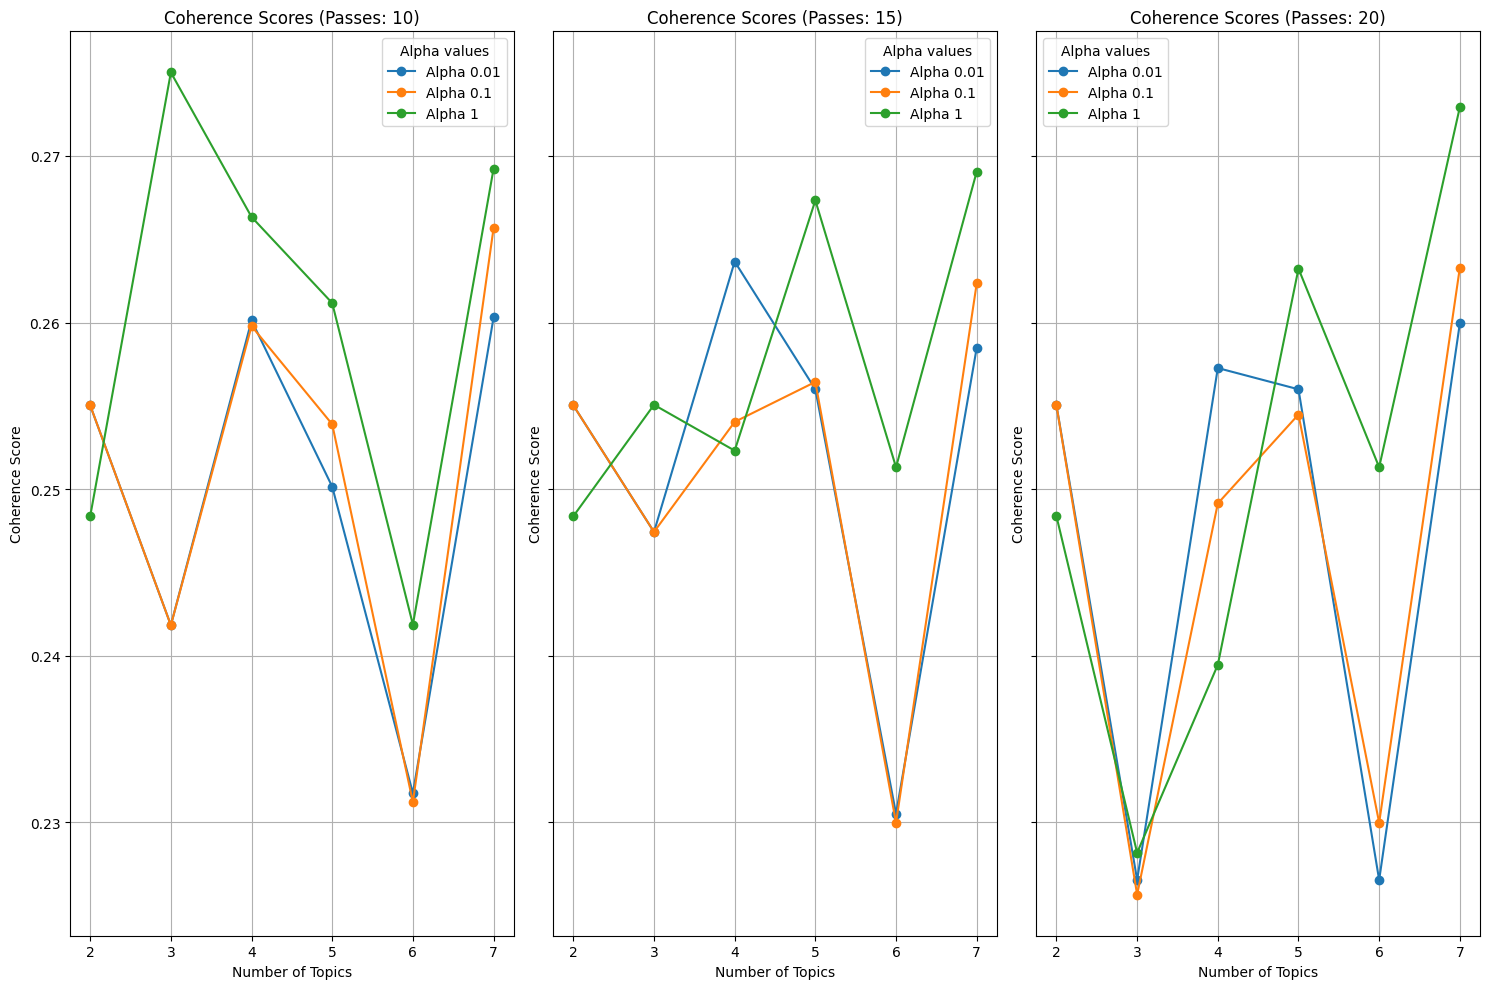

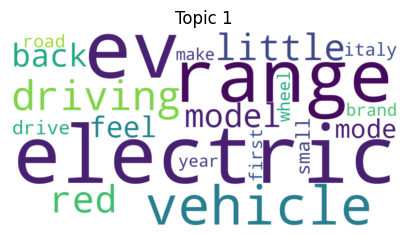

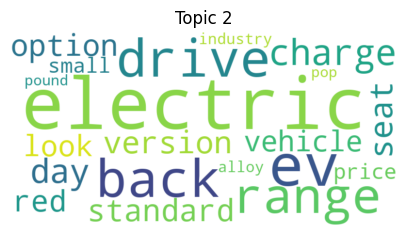

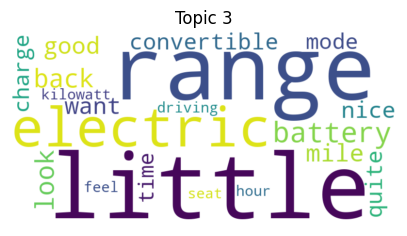

In [9]:
RANDOM_SEED = 42
opinionLeaders500 = opinionLeaders500.drop(columns=['Date', 'Title', 'Channel Name'])

# Update stopwords handling
custom_stopwords = set(stopwords.words('english')).union({
    'car', 'cars', 'fiat', 'jeep', 'hyundai', 'kona', 'stellantis', 'market', 'available',
    'would', 'also', 'new', 'level', 'like', 'even', 'according', 'offered', 'move',
    'one', 'content', 'information', 'interests', 'activity', 'mean', 'go', 'quit',
    'got', 'much', 'actual', 'thing', 'bit', 'see', 'think', 'yeah', 'know', 'and', 
    'way', 'come', 'presented', 'example', 'esposito', 'lee', 'torque', 'ready', 
    'since', 'still', 'two', 'sold', 'week', 'sherpa', 'around', 'use', 'um', 
    'together', 'us', 'really', 'america', 'well', 'mirafiori', 'campaign', 'north',
    'sales', 'bag', 'says', 'get', 'world', 'germani', 'belgium', 'spain',
    'uh', 'oh', 'im', 'thats', 'youre', 'weve', 'dont', 'actually', 'ahmed', 'work', 'reuters','youve','there','going',
    'gelateria', 'list', 'required', 'instead', 'added', 'inbox', 'honda', 'help', 'dedicated',
    'inform', 'news', 'group', 'report', 'couldnt', 'three', 'including', 'however', 'people'
})

def preprocess(text):
    # remove tabs and newlines
    text = re.sub(r'[\n\t]', ' ', text)
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token.isalpha() and token not in custom_stopwords]
    lemmatizer = nltk.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return tokens

# Processing the documents
processed_docs = [preprocess(doc) for doc in opinionLeaders500['Text']]
dictionary = corpora.Dictionary(processed_docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Updated coherence function to iterate over multiple parameters
def compute_coherence_values(dictionary, corpus, texts, num_topics_range, alpha_range, passes_range):
    coherence_results = []
    model_list = []
    for num_passes in passes_range:
        for alpha in alpha_range:
            for num_topics in num_topics_range:
                model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha=alpha, passes=num_passes, random_state=RANDOM_SEED)
                model_list.append(model)
                coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
                coherence_results.append({
                    "model": model,
                    "alpha": alpha,
                    "num_topics": num_topics,
                    "passes": num_passes,
                    "coherence": coherencemodel.get_coherence()
                })
    return model_list, coherence_results

# Compute models and coherence
num_topics_range = range(2, 8)
alpha_range = [0.01, 0.1,  1]
passes_range = range(10, 21, 5)
model_list, coherence_results = compute_coherence_values(dictionary, bow_corpus, processed_docs, num_topics_range, alpha_range, passes_range)

# Finding and displaying the best model
optimal_result_OL500 = max(coherence_results, key=lambda x: x['coherence'])
print(f"Optimal settings: {optimal_result_OL500['num_topics']} topics, Alpha: {optimal_result_OL500['alpha']}, Passes: {optimal_result_OL500['passes']}, Coherence Score: {optimal_result_OL500['coherence']}")


# Plotting the coherence scores
def plot_coherence_scores(coherence_results):
    # Get unique values for passes, alphas, and number of topics
    passes_values = sorted(set(result['passes'] for result in coherence_results))
    alpha_values = sorted(set(result['alpha'] for result in coherence_results))
    num_topics_values = sorted(set(result['num_topics'] for result in coherence_results))
    
    # Determine the layout of subplots
    num_plots = len(passes_values)
    num_cols = 3  # Define the number of columns in the subplot grid
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the required number of rows

    # Create subplots with horisontal layout
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10), sharey=True)
    axes = axes.flatten()  # Flatten in case we have a single row

    for idx, num_passes in enumerate(passes_values):
        ax = axes[idx]
        filtered_results = [result for result in coherence_results if result['passes'] == num_passes]

        for alpha in alpha_values:
            x = [result['num_topics'] for result in filtered_results if result['alpha'] == alpha]
            y = [result['coherence'] for result in filtered_results if result['alpha'] == alpha]
            ax.plot(x, y, marker='o', label=f'Alpha {alpha}')

        ax.set_title(f"Coherence Scores (Passes: {num_passes})")
        ax.set_xlabel("Number of Topics")
        ax.set_ylabel("Coherence Score")
        ax.legend(title='Alpha values')
        ax.grid(True)

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

# Assuming `coherence_results` is your list of dictionaries containing the coherence data
plot_coherence_scores(coherence_results)

# Visualize topics using word clouds
optimal_model_OL500 = optimal_result_OL500['model']
optimal_num_topics_OL500 = optimal_result_OL500['num_topics']
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white', stopwords=custom_stopwords, random_state=RANDOM_SEED)
for i in range(optimal_num_topics_OL500):
    plt.figure(figsize=(5, 4))
    topic_words = dict(optimal_model_OL500.show_topic(i, 20))
    filtered_words = {word: freq for word, freq in topic_words.items() if word not in custom_stopwords}
    plt.imshow(wordcloud.generate_from_frequencies(filtered_words), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {i + 1}")
    plt.show()

In [10]:
lda_OL500 = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=optimal_num_topics_OL500, alpha=optimal_result_OL500['alpha'], passes=optimal_result_OL500['passes'], random_state=RANDOM_SEED)

In [11]:
for idx, topic in lda_OL500.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.009*"electric" + 0.009*"ev" + 0.007*"range" + 0.007*"vehicle" + 0.006*"driving" + 0.005*"red" + 0.005*"little" + 0.005*"model" + 0.004*"back" + 0.004*"feel"
Topic: 1 
Words: 0.009*"electric" + 0.006*"ev" + 0.004*"back" + 0.004*"drive" + 0.004*"range" + 0.004*"charge" + 0.004*"day" + 0.003*"seat" + 0.003*"version" + 0.003*"standard"
Topic: 2 
Words: 0.010*"little" + 0.009*"range" + 0.008*"electric" + 0.008*"battery" + 0.007*"look" + 0.006*"back" + 0.006*"mile" + 0.006*"good" + 0.005*"want" + 0.005*"quite"


In [12]:
# Visualise topics using pyLDAvis
OL500_vis = gensimvis.prepare(lda_OL500, bow_corpus, dictionary, sort_topics=False)  # Ensure reproducibility by setting sort_topics to False
pyLDAvis.display(OL500_vis)

In [13]:
# Get the topic distribution for each document
OL500_topic_matrix = [lda_OL500[doc] for doc in bow_corpus]

# Extract topic probabilities and add them as columns
opinionLeaders500['Topic 1'] = [dict(doc).get(0, 0) for doc in OL500_topic_matrix]
opinionLeaders500['Topic 2'] = [dict(doc).get(1, 0) for doc in OL500_topic_matrix]
opinionLeaders500['Topic 3'] = [dict(doc).get(2, 0) for doc in OL500_topic_matrix]

# Add 'Date' columns from the original table
date_map = dict(zip(opinionLeaders500_original['ID'], opinionLeaders500_original['Date']))
opinionLeaders500['Date'] = opinionLeaders500['ID'].map(date_map)

# Display the table with the new topic columns
opinionLeaders500.head()

,ID,Text,Topic 1,Topic 2,Topic 3,Date
0,https://news.google.com/articles/CBMiHmh0dHBzO...,"The new target of 200,000 units includes the a...",0.270191,0.631496,0.098313,2024-05-28
1,https://news.google.com/articles/CBMiMmh0dHBzO...,The Fiat 500e not only offers the lowest MSRP ...,0.199512,0.782261,0.018227,2024-05-08
2,https://news.google.com/articles/CBMiNmh0dHBzO...,See also: FIAT 500e: Electric Icon Arrives in ...,0.083704,0.870092,0.046204,2024-02-15
3,https://news.google.com/articles/CBMiP2h0dHBzO...,"Priced at an MSRP of $32,500, the Fiat 500e in...",0.733447,0.250181,0.016371,2024-02-21
4,https://news.google.com/articles/CBMiPWh0dHBzO...,"""Normal is an illusion. What's normal for the ...",0.734579,0.131818,0.133602,2024-06-18


In [14]:
# Define a function to get the sentiment of a text
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Apply sentiment analysis to each document
opinionLeaders500['Sentiment'] = opinionLeaders500['Text'].apply(get_sentiment)

# Determine the primary topic for each document
opinionLeaders500['Primary_Topic'] = opinionLeaders500[['Topic 1', 'Topic 2', 'Topic 3']].idxmax(axis=1)

# Calculate mean sentiment for each topic
topic_sentiment_OL500 = opinionLeaders500.groupby('Primary_Topic')['Sentiment'].mean()
print(topic_sentiment_OL500)

# Calculate mean sentiment for each topic monthly
opinionLeaders500['Month'] = pd.to_datetime(opinionLeaders500['Date']).dt.to_period('M')
monthly_topic_sentiment_OL500 = opinionLeaders500.groupby(['Primary_Topic', 'Month'])['Sentiment'].mean()
# Print per month, not per topic
monthly_topic_sentiment_OL500 = opinionLeaders500.pivot_table(index='Month', columns='Primary_Topic', values='Sentiment', aggfunc='mean')
print(monthly_topic_sentiment_OL500)


Primary_Topic
Topic 1    0.215957
Topic 2    0.158548
Topic 3    0.132156
Name: Sentiment, dtype: float64
Primary_Topic   Topic 1   Topic 2   Topic 3
Month                                      
2020-12             NaN       NaN  0.158368
2021-05             NaN       NaN  0.160607
2021-06             NaN       NaN  0.194351
2022-02             NaN       NaN  0.156924
2022-05             NaN       NaN  0.191824
2022-11             NaN       NaN  0.160326
2022-12             NaN       NaN  0.126862
2023-08             NaN       NaN  0.096446
2023-09        0.115670       NaN       NaN
2023-10             NaN  0.150232       NaN
2023-11        0.296360       NaN  0.092044
2023-12        0.150220  0.136227  0.117274
2024-01        0.074895  0.051338  0.109419
2024-02        0.182340  0.172552  0.000000
2024-03        0.214966  0.153939       NaN
2024-04        0.192684       NaN       NaN
2024-05        0.153435  0.190357  0.229272
2024-06        0.341571  0.234091  0.099803


In [15]:
# Check the proportion of negative sentiment articles
negative_sentiment_OL500 = opinionLeaders500[opinionLeaders500['Sentiment'] < 0]
print('Proportion of negative sentiment articles: ')
print(len(negative_sentiment_OL500)/len(opinionLeaders500))
print('Number of negative sentiment articles: ')
print(len(negative_sentiment_OL500))

# Check the proportion of negative sentiment articles per topic
negative_sentiment_per_topic_OL500 = negative_sentiment_OL500.groupby('Primary_Topic').size()
total_articles_per_topic_OL500 = opinionLeaders500.groupby('Primary_Topic').size()
negative_sentiment_proportion_per_topic_OL500 = negative_sentiment_per_topic_OL500 / total_articles_per_topic_OL500
print('Proportion of negative sentiment articles per topic: ')
print(negative_sentiment_proportion_per_topic_OL500)

# Check the proportion of negative sentiment articles per month
negative_sentiment_per_month_OL500 = negative_sentiment_OL500.groupby('Month').size()
total_articles_per_month_OL500 = opinionLeaders500.groupby('Month').size()
negative_sentiment_proportion_per_month_OL500 = negative_sentiment_per_month_OL500 / total_articles_per_month_OL500
print('Proportion of negative sentiment articles per month: ')
print(negative_sentiment_proportion_per_month_OL500)

Proportion of negative sentiment articles: 
0.011627906976744186
Number of negative sentiment articles: 
1
Proportion of negative sentiment articles per topic: 
Primary_Topic
Topic 1    0.021277
Topic 2         NaN
Topic 3         NaN
dtype: float64
Proportion of negative sentiment articles per month: 
Month
2020-12         NaN
2021-05         NaN
2021-06         NaN
2022-02         NaN
2022-05         NaN
2022-11         NaN
2022-12         NaN
2023-08         NaN
2023-09         NaN
2023-10         NaN
2023-11         NaN
2023-12         NaN
2024-01         NaN
2024-02         NaN
2024-03         NaN
2024-04         NaN
2024-05         NaN
2024-06    0.058824
Freq: M, dtype: float64


# Clustering analysis


In [110]:
# Preprocess function
def preprocess(text):
    if isinstance(text, str):
        text = re.sub(r'\b\w{1,2}\b', '', text)  # Remove short words
        tokens = nltk.word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalpha() and word not in custom_stopwords]
        return tokens
    else:
        return []

# Custom stopwords
custom_stopwords = set(stopwords.words('english')).union({
    'car', 'cars', 'fiat', 'jeep', 'hyundai', 'kona', 'stellantis', 'market', 'available',
    'would', 'also', 'new', 'level', 'like', 'even', 'according', 'offered', 'move',
    'one', 'content', 'information', 'interests', 'activity', 'mean', 'go', 'quit',
    'got', 'much', 'actual', 'thing', 'bit', 'see', 'think', 'yeah', 'know', 'and', 
    'way', 'come', 'presented', 'example', 'esposito', 'lee', 'torque', 'ready', 
    'since', 'still', 'two', 'sold', 'week', 'sherpa', 'around', 'use', 'um', 
    'together', 'us', 'really', 'america', 'well', 'mirafiori', 'campaign', 'north',
    'sales', 'bag', 'says', 'get', 'world', 'germani', 'belgium', 'spain',
    'uh', 'oh', 'im', 'thats', 'youre', 'weve', 'dont', 'actually', 'ahmed', 'work', 'reuters','youve','there','going',
    'gelateria', 'list', 'required', 'instead', 'added', 'inbox', 'honda', 'help', 'dedicated',
    'inform', 'news', 'group', 'report', 'couldnt', 'three', 'including', 'however', 'people'
})

# Load the datasets separately
df1 = pd.read_csv(r'C:\Users\atani\OneDrive - City, University of London\Tanisha\ARP\22_Jul_500e_Articels_23_June_full.csv')
df2 = pd.read_csv(r'C:\Users\atani\OneDrive - City, University of London\Tanisha\ARP\500e - YouTube Transcripts with Date.csv')

# Inspect columns
print("Columns in df1:", df1.columns)
print("Columns in df2:", df2.columns)

# Rename columns to avoid duplication
df1 = df1.rename(columns={'URL': 'ID_1', 'Published': 'Date_1', 'Transcript': 'Text', 'VideoID': 'ID_2'})
df2 = df2.rename(columns={'URL': 'ID_3', 'Published': 'Date_2', 'Transcript': 'Text', 'VideoID': 'ID_4'})

# Inspect columns again after renaming
print("Columns in df1 after renaming:", df1.columns)
print("Columns in df2 after renaming:", df2.columns)

# Drop unnecessary columns before concatenation
df1 = df1.drop(columns=[col for col in ['ID_1', 'ID_2'] if col in df1.columns])
df2 = df2.drop(columns=[col for col in ['ID_3', 'ID_4'] if col in df2.columns])

# Concatenate the datasets
opinionLeaders500 = pd.concat([df1, df2], axis=0).reset_index(drop=True)

# Inspect the concatenated DataFrame columns
print("Columns in concatenated DataFrame:", opinionLeaders500.columns)

# Process the 'Date' column if needed
if 'Date_1' in opinionLeaders500.columns and 'Date_2' in opinionLeaders500.columns:
    opinionLeaders500['Date'] = pd.to_datetime(opinionLeaders500['Date_1'].fillna(opinionLeaders500['Date_2'])).dt.strftime('%Y-%m-%d')
    opinionLeaders500 = opinionLeaders500.drop(columns=['Date_1', 'Date_2'])
else:
    opinionLeaders500['Date'] = pd.to_datetime(opinionLeaders500['Date']).dt.strftime('%Y-%m-%d')

# Drop unnecessary columns
opinionLeaders500 = opinionLeaders500.drop(columns=['Title', 'Channel Name'])

# Reset index
opinionLeaders500 = opinionLeaders500.reset_index(drop=True)

# Processing the documents
processed_docs = [" ".join(preprocess(doc)) for doc in opinionLeaders500['Text']]

Columns in df1: Index(['URL', 'Text', 'Published'], dtype='object')
Columns in df2: Index(['VideoID', 'Title', 'Channel Name', 'Transcript', 'Date'], dtype='object')
Columns in df1 after renaming: Index(['ID_1', 'Text', 'Date_1'], dtype='object')
Columns in df2 after renaming: Index(['ID_4', 'Title', 'Channel Name', 'Text', 'Date'], dtype='object')
Columns in concatenated DataFrame: Index(['Text', 'Date_1', 'Title', 'Channel Name', 'Date'], dtype='object')


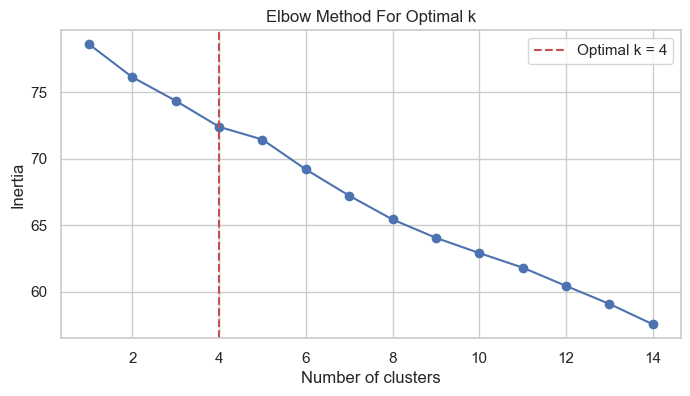

The optimal number of clusters based on the Elbow Method is: 4


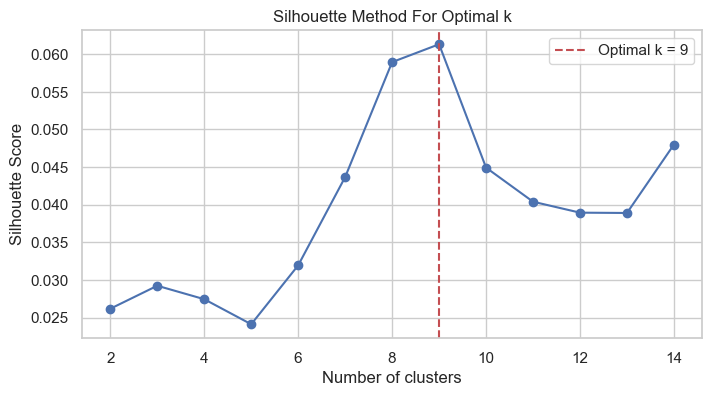

The optimal number of clusters based on the Silhouette Method is: 9


In [111]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=list(custom_stopwords))  # Convert stopwords to list
X_tfidf = tfidf_vectorizer.fit_transform(processed_docs)

# Apply the Elbow Method
inertia = []
K_range = range(1, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

# Find the "elbow" point
def find_elbow(inertia, K_range):
    slopes = np.diff(inertia)
    optimal_k = np.argmax(np.diff(slopes)) + 2  # +2 because np.diff reduces the array size by 1 and we start from k=2
    return optimal_k

optimal_k_elbow = find_elbow(inertia, K_range)

# Plotting the inertia to find the elbow
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.axvline(x=optimal_k_elbow, color='r', linestyle='--', label=f'Optimal k = {optimal_k_elbow}')
plt.legend()
plt.show()

print(f"The optimal number of clusters based on the Elbow Method is: {optimal_k_elbow}")

# Apply the Silhouette Method
silhouette_scores = []

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    silhouette_scores.append(silhouette_score(X_tfidf, kmeans.labels_))

optimal_k_silhouette = np.argmax(silhouette_scores) + 2  # +2 because the range starts from 2

# Plotting the silhouette scores to find the optimal number of clusters
plt.figure(figsize=(8, 4))
plt.plot(range(2, 15), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.axvline(x=optimal_k_silhouette, color='r', linestyle='--', label=f'Optimal k = {optimal_k_silhouette}')
plt.legend()
plt.show()

print(f"The optimal number of clusters based on the Silhouette Method is: {optimal_k_silhouette}")

# Decide on the optimal number of clusters
optimal_k = max(optimal_k_elbow, optimal_k_silhouette)  # Choose the higher number for better separation



Cluster 1 samples:
- The first all-electric Fiat 500e vehicles destined for the United States rolled off the line this week at the Mirafiori Assembly Plant in Turin, Italy. The feature-packed, two-door, battery-electric v...
- The iconic minicar built in Italy returns to the U.S. market after the automaker ended production of the Fiat 500 and its electric version in 2019 in Mexico. Former Fiat Chrysler Automobiles NV CEO Se...
- " It would be surprising to see the 500e hybrid offered in North America, when the challenge is to revive the model in its electric form. " •    Fiat plans to modify its all-electric 500 and offer a h...


Cluster 2 samples:
- Fiat is directly courting those Saks shoppers, and with its U.S. sales having cratered since 2021, change is warranted. It’s also transforming how it sells cars, with direct ordering and new models re...
- Two drive notes for the price of one this week. Next up: A 2024 Fiat 500e Inspired by Beauty I made it -- more on that below. What els

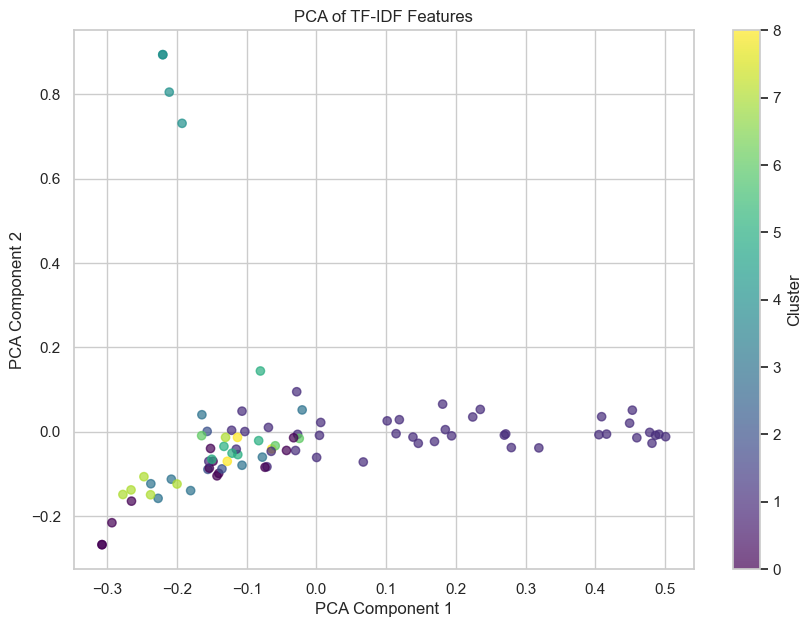

Cluster 1 Top Keywords: italy, first, europe, plant, vehicles, sale, price, states, dealer, vehicle

Cluster 2 Top Keywords: range, electric, little, back, battery, small, drive, normal, red, driving

Cluster 3 Top Keywords: includes, addition, engine, suggested, retail, red, edition, manufacturer, models, said

Cluster 4 Top Keywords: industry, electric, global, media, professionals, government, red, vehicles, engage, hagman

Cluster 5 Top Keywords: providing, managing, boasts, reaching, excellent, performance, mph, road, seconds, horsepower

Cluster 6 Top Keywords: inspired, logo, chrome, automaker, windows, channel, caps, without, beauty, side

Cluster 7 Top Keywords: launched, old, model, simple, city, motorway, reviews, direct, needed, entirely

Cluster 8 Top Keywords: spike, italy, creative, giancarlo, italian, brand, advertising, social, spot, channels

Cluster 9 Top Keywords: unique, bespoke, fabric, features, finish, entirely, roof, beautiful, works, excited



In [115]:
# Apply K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# Add cluster labels to the DataFrame
opinionLeaders500['Cluster'] = clusters

# Print samples from each cluster
for cluster in range(optimal_k):
    print(f"Cluster {cluster + 1} samples:")
    samples = opinionLeaders500[opinionLeaders500['Cluster'] == cluster].sample(3, random_state=42)
    for index, row in samples.iterrows():
        print(f"- {row['Text'][:200]}...")  # Print the first 200 characters of each sample
    print("\n")

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of TF-IDF Features')
plt.show()

# Keyword Analysis for Each Cluster
feature_names = tfidf_vectorizer.get_feature_names_out()

for cluster in range(optimal_k):
    cluster_tfidf = X_tfidf[clusters == cluster]
    cluster_mean_tfidf = np.mean(cluster_tfidf, axis=0)
    
    if cluster_tfidf.shape[0] > 0:  # Check if the cluster_tfidf matrix is not empty
        # Ensure cluster_mean_tfidf is a 1D array
        cluster_mean_tfidf = np.array(cluster_mean_tfidf).flatten()
        
        # Get indices of top 10 features
        top_indices = np.argsort(cluster_mean_tfidf)[-10:][::-1]
        
        # Get top 10 keywords
        top_keywords = [feature_names[i] for i in top_indices]
        
        print(f"Cluster {cluster + 1} Top Keywords: {', '.join(top_keywords)}\n")

# Opinion Leaders 600e: Articles & Youtube Video Transcripts

In [16]:
articles600_original = pd.read_csv(r'C:\Users\atani\OneDrive - City, University of London\Tanisha\ARP\22_Jul_600e_Articels_23_June_full.csv')
articles600 = articles600_original.copy()
# rename URL to ID
articles600.rename(columns={'URL': 'ID'}, inplace=True)
# Rename Published to Date
articles600.rename(columns={'Published': 'Date'}, inplace=True)
# Date to YYYY-MM-DD without time dt.strftime('%Y-%m-%d')
articles600['Date'] = pd.to_datetime(articles600['Date']).dt.strftime('%Y-%m-%d')

articles600.head()

,ID,Text,Date
0,https://news.google.com/articles/CBMiHmh0dHBzO...,JAKARTA - Fiat recently revealed their latest ...,2023-12-29
1,https://news.google.com/articles/CBMiJ2h0dHBzO...,"Customers asked for more crossovers, and Fiat ...",2023-08-21
2,https://news.google.com/articles/CBMiJ2h0dHBzO...,\nRelatively affordable to buy. Very useable 2...,2023-09-27
3,https://news.google.com/articles/CBMiKWh0dHBzO...,4.0 out of 5 The ‘Frappuccino' of the small el...,2023-09-22
4,https://news.google.com/articles/CBMiNGh0dHBzO...,There are two specifications available on the ...,2024-03-05


In [17]:
len(articles600)

83

In [18]:
transcripts600 = pd.read_csv(r'C:\Users\atani\OneDrive - City, University of London\Tanisha\ARP\600e - YouTube Transcripts with Date.csv')
# rename Transcript to Text
transcripts600 = transcripts600.rename(columns={'Transcript': 'Text'})
# rename Video ID to ID 
transcripts600 = transcripts600.rename(columns={'VideoID': 'ID'})
transcripts600.head()

,ID,Title,Channel Name,Text,Date
0,AXGNb76QgH0,NEW Fiat 600E Review: Fantastic or Flawed? | 4K,AutoTrader,foreign 500e and you should it's brilliant but...,2023-11-27
1,MvgfB8kcS1s,I wasn't expecting to like THIS car so much?! ...,Auto Social UK,fats have always had this fabulous way of winn...,2024-04-07
2,eZMrw98nHgU,Fiat 600e FIRST UK DRIVE. Does the 500e’s big ...,Electrifying,I know what you're thinking Nikki's lost her m...,2024-03-08
3,HAZC8wrWQGM,All-new 600e Review: Fiat's family friendly EV,CarGurus UK,the Fiat 600e is the latest electric car from ...,2023-09-27
4,Z6vFfBmTXuA,Is this car a bit *too* quirky? Fiat 600e Review,Electroheads,hello Electro heads Tish here and welcome back...,2023-10-03


In [19]:
len(transcripts600)

11

In [20]:
# combine vertically data frames by ID and TEXT
opinionLeaders600_original = pd.concat([articles600, transcripts600], axis=0)
opinionLeaders600 = opinionLeaders600_original.copy()
opinionLeaders600 = opinionLeaders600.reset_index(drop=True)
print(opinionLeaders600.head())
print(len(opinionLeaders600))


                                                  ID  \
0  https://news.google.com/articles/CBMiHmh0dHBzO...   
1  https://news.google.com/articles/CBMiJ2h0dHBzO...   
2  https://news.google.com/articles/CBMiJ2h0dHBzO...   
3  https://news.google.com/articles/CBMiKWh0dHBzO...   
4  https://news.google.com/articles/CBMiNGh0dHBzO...   

                                                Text        Date Title  \
0  JAKARTA - Fiat recently revealed their latest ...  2023-12-29   NaN   
1  Customers asked for more crossovers, and Fiat ...  2023-08-21   NaN   
2  \nRelatively affordable to buy. Very useable 2...  2023-09-27   NaN   
3  4.0 out of 5 The ‘Frappuccino' of the small el...  2023-09-22   NaN   
4  There are two specifications available on the ...  2024-03-05   NaN   

  Channel Name  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  
94


In [21]:
# check if emoty ID and Text exist
print(opinionLeaders600[opinionLeaders600['ID'].isnull()])
print(opinionLeaders600[opinionLeaders600['Text'].isnull()])
print(opinionLeaders600[opinionLeaders600['Date'].isnull()])

Empty DataFrame
Columns: [ID, Text, Date, Title, Channel Name]
Index: []
Empty DataFrame
Columns: [ID, Text, Date, Title, Channel Name]
Index: []
Empty DataFrame
Columns: [ID, Text, Date, Title, Channel Name]
Index: []


Optimal settings: 6 topics, Alpha: 1, Passes: 20, Coherence Score: 0.37526320272728936


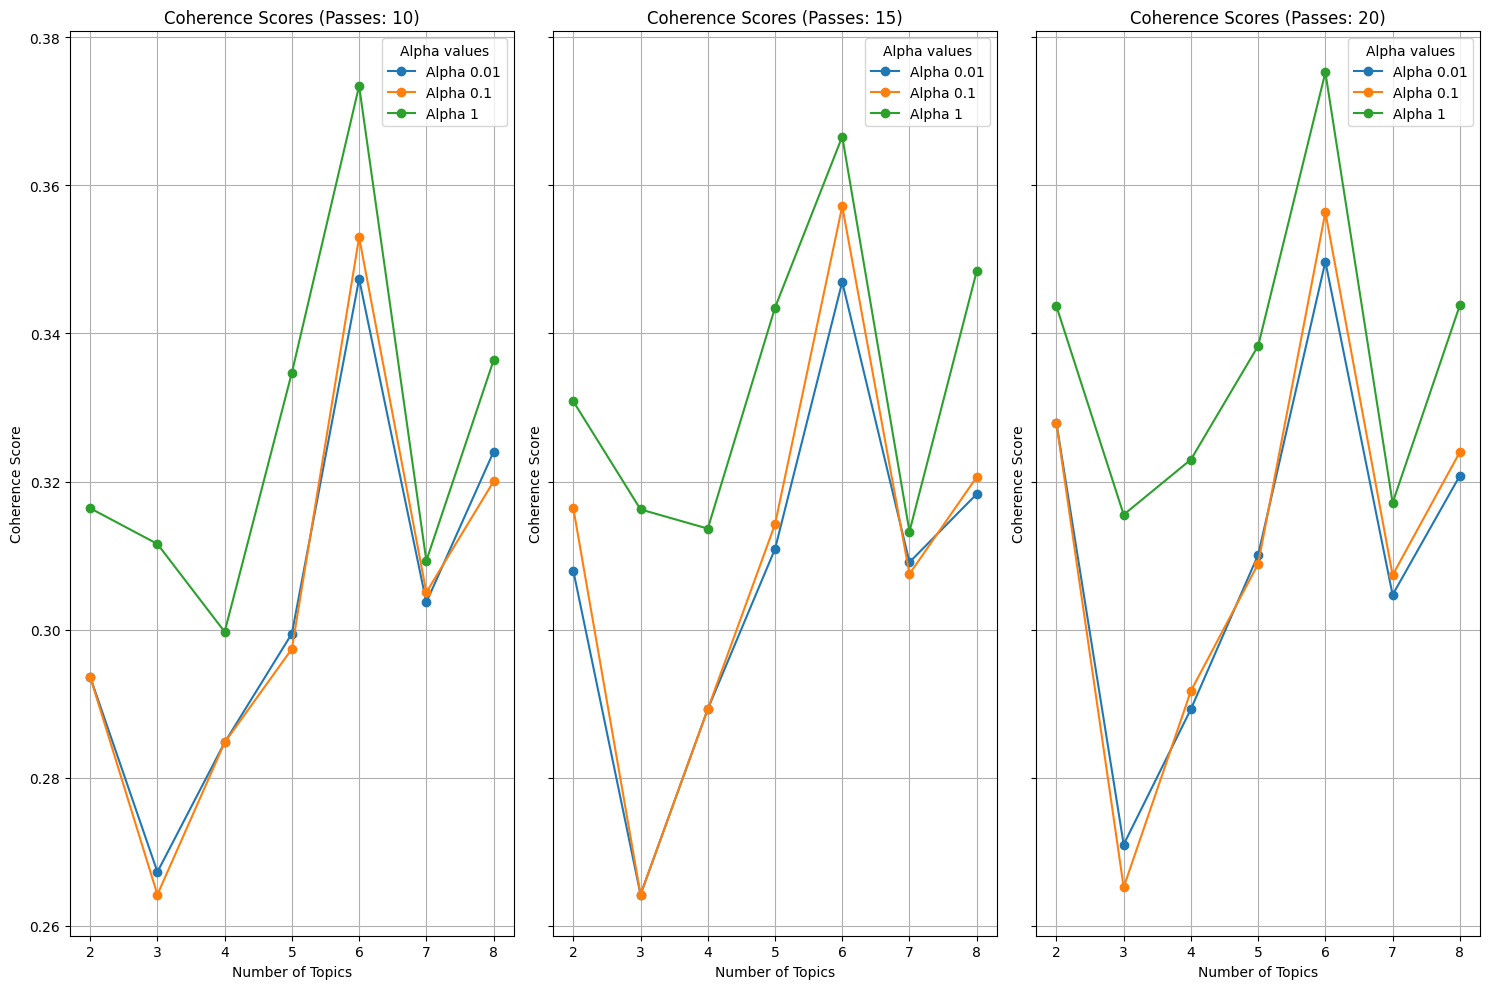

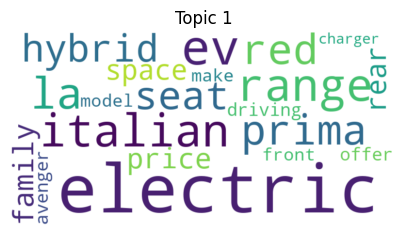

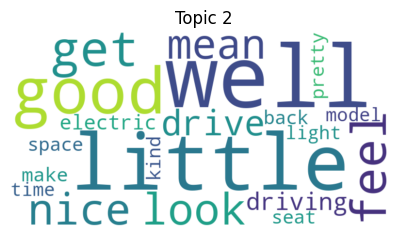

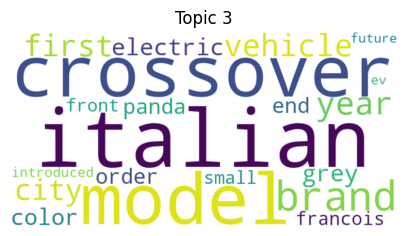

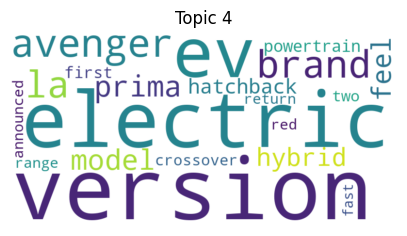

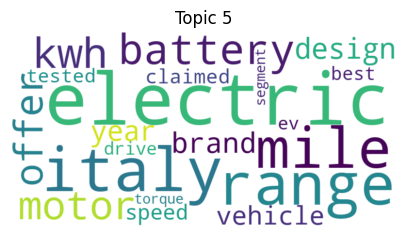

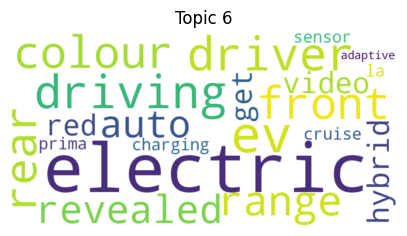

In [22]:
# drop published title and channel name
opinionLeaders600 = opinionLeaders600.drop(columns=['Date', 'Title', 'Channel Name'])

custom_stopwords = set(stopwords.words('english')).union({'car', 'cars', 'fiat', 'jeep', 'hyundai', 'kona', 'stellantis', 'market',
                         'available', 'would', 'also', 'new', 'level', 'like', 'even', 'according',
                         'offered', 'move', 'one', 'content', 'information', 'interests', 'activity',
                         'presented', 'example','honda','got','thing',
                         'per','really','going','think','quite','know','much','actually','go','bit','around',
                         'um','still','kia', 'see','lot','hp','may','take','tipo'
}) 

# Processing the documents
processed_docs = [preprocess(doc) for doc in opinionLeaders600['Text']]
dictionary = corpora.Dictionary(processed_docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Compute models and coherence
num_topics_range = range(2, 9)
alpha_range = [0.01, 0.1,  1]
passes_range = range(10, 21, 5)
model_list, coherence_results = compute_coherence_values(dictionary, bow_corpus, processed_docs, num_topics_range, alpha_range, passes_range)

# Finding and displaying the best model
optimal_result_OL600 = max(coherence_results, key=lambda x: x['coherence'])
print(f"Optimal settings: {optimal_result_OL600['num_topics']} topics, Alpha: {optimal_result_OL600['alpha']}, Passes: {optimal_result_OL600['passes']}, Coherence Score: {optimal_result_OL600['coherence']}")

# Assuming `coherence_results` is your list of dictionaries containing the coherence data
plot_coherence_scores(coherence_results)

# Visualize topics using word clouds
optimal_model_OL600 = optimal_result_OL600['model']
optimal_num_topics_OL600 = optimal_result_OL600['num_topics']
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white', stopwords=custom_stopwords, random_state=RANDOM_SEED)
for i in range(optimal_num_topics_OL600):
    plt.figure(figsize=(5, 4))
    topic_words = dict(optimal_model_OL600.show_topic(i, 20))
    filtered_words = {word: freq for word, freq in topic_words.items() if word not in custom_stopwords}
    plt.imshow(wordcloud.generate_from_frequencies(filtered_words), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {i + 1}")
    plt.show()

In [23]:
lda_OL600 = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=optimal_num_topics_OL600, alpha=optimal_result_OL600['alpha'], passes=optimal_result_OL600['passes'], random_state=RANDOM_SEED)

In [24]:
for idx, topic in lda_OL600.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.019*"electric" + 0.009*"ev" + 0.008*"italian" + 0.007*"range" + 0.007*"la" + 0.006*"red" + 0.006*"prima" + 0.006*"seat" + 0.005*"hybrid" + 0.005*"price"
Topic: 1 
Words: 0.012*"well" + 0.009*"little" + 0.008*"good" + 0.008*"get" + 0.008*"feel" + 0.006*"look" + 0.006*"nice" + 0.006*"mean" + 0.005*"drive" + 0.005*"driving"
Topic: 2 
Words: 0.009*"italian" + 0.008*"crossover" + 0.008*"model" + 0.007*"brand" + 0.007*"year" + 0.006*"vehicle" + 0.006*"first" + 0.005*"city" + 0.005*"electric" + 0.005*"grey"
Topic: 3 
Words: 0.012*"version" + 0.009*"electric" + 0.007*"ev" + 0.007*"avenger" + 0.007*"brand" + 0.006*"la" + 0.006*"prima" + 0.006*"model" + 0.005*"feel" + 0.005*"hybrid"
Topic: 4 
Words: 0.011*"electric" + 0.008*"italy" + 0.007*"range" + 0.007*"mile" + 0.006*"battery" + 0.006*"kwh" + 0.005*"motor" + 0.005*"offer" + 0.005*"design" + 0.005*"brand"
Topic: 5 
Words: 0.014*"electric" + 0.007*"ev" + 0.006*"driver" + 0.006*"driving" + 0.006*"front" + 0.006*"colour" + 0.00

In [25]:
# Visualise topics using pyLDAvis
OL600_vis = gensimvis.prepare(lda_OL600, bow_corpus, dictionary, sort_topics=False)  # Ensure reproducibility by setting sort_topics to False
pyLDAvis.display(OL600_vis)

In [26]:
# Get the topic distribution for each document
OL600_topic_matrix = [lda_OL600[doc] for doc in bow_corpus]

# Extract topic probabilities and add them as columns
opinionLeaders600['Topic 1'] = [dict(doc).get(0, 0) for doc in OL600_topic_matrix]
opinionLeaders600['Topic 2'] = [dict(doc).get(1, 0) for doc in OL600_topic_matrix]
opinionLeaders600['Topic 3'] = [dict(doc).get(2, 0) for doc in OL600_topic_matrix]
opinionLeaders600['Topic 4'] = [dict(doc).get(3, 0) for doc in OL600_topic_matrix]
opinionLeaders600['Topic 5'] = [dict(doc).get(4, 0) for doc in OL600_topic_matrix]
opinionLeaders600['Topic 6'] = [dict(doc).get(5, 0) for doc in OL600_topic_matrix]

# Add 'Date' columns from the original table
date_map = dict(zip(opinionLeaders600_original['ID'], opinionLeaders600_original['Date']))
opinionLeaders600['Date'] = opinionLeaders600['ID'].map(date_map)

# Display the table with the new topic columns
opinionLeaders600.head()

,ID,Text,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Date
0,https://news.google.com/articles/CBMiHmh0dHBzO...,JAKARTA - Fiat recently revealed their latest ...,0.024169,0.025471,0.025480,0.027455,0.028259,0.869167,2023-12-29
1,https://news.google.com/articles/CBMiJ2h0dHBzO...,"Customers asked for more crossovers, and Fiat ...",0.000000,0.000000,0.972126,0.000000,0.000000,0.000000,2023-08-21
2,https://news.google.com/articles/CBMiJ2h0dHBzO...,\nRelatively affordable to buy. Very useable 2...,0.989456,0.000000,0.000000,0.000000,0.000000,0.000000,2023-09-27
3,https://news.google.com/articles/CBMiKWh0dHBzO...,4.0 out of 5 The ‘Frappuccino' of the small el...,0.966919,0.014560,0.000000,0.000000,0.000000,0.000000,2023-09-22
4,https://news.google.com/articles/CBMiNGh0dHBzO...,There are two specifications available on the ...,0.532094,0.169748,0.020025,0.033288,0.019762,0.225083,2024-03-05


In [27]:
# Apply sentiment analysis to each document
opinionLeaders600['Sentiment'] = opinionLeaders600['Text'].apply(get_sentiment)

# Determine the primary topic for each document
opinionLeaders600['Primary_Topic'] = opinionLeaders600[['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6']].idxmax(axis=1)

# Calculate mean sentiment for each topic
topic_sentiment_OL600 = opinionLeaders600.groupby('Primary_Topic')['Sentiment'].mean()
print(topic_sentiment_OL600)

# Calculate mean sentiment for each topic monthly
opinionLeaders600['Month'] = pd.to_datetime(opinionLeaders600['Date']).dt.to_period('M')
monthly_topic_sentiment_OL600 = opinionLeaders600.groupby(['Primary_Topic', 'Month'])['Sentiment'].mean()
# Print per month, not per topic
monthly_topic_sentiment_OL600 = opinionLeaders600.pivot_table(index='Month', columns='Primary_Topic', values='Sentiment', aggfunc='mean')
print(monthly_topic_sentiment_OL600)

Primary_Topic
Topic 1    0.144203
Topic 2    0.143059
Topic 3    0.083214
Topic 4    0.118453
Topic 5    0.161653
Topic 6    0.125406
Name: Sentiment, dtype: float64
Primary_Topic   Topic 1   Topic 2   Topic 3   Topic 4   Topic 5   Topic 6
Month                                                                    
2023-01             NaN  0.106061       NaN       NaN       NaN       NaN
2023-06        0.185965  0.031216  0.194131       NaN  0.170171  0.118508
2023-07        0.137610  0.220770  0.053570  0.131587  0.164832  0.111645
2023-08             NaN  0.136316  0.158797       NaN  0.068182       NaN
2023-09        0.138004  0.182805 -0.221212  0.034613       NaN  0.024857
2023-10             NaN       NaN       NaN  0.129497  0.194814  0.197358
2023-11        0.223077  0.141917       NaN  0.144443       NaN       NaN
2023-12        0.074432       NaN  0.016607  0.267273  0.179497  0.097619
2024-01             NaN       NaN       NaN       NaN       NaN  0.199762
2024-03        0.166

In [28]:
# Check the proportion of negative sentiment articles
negative_sentiment_OL600 = opinionLeaders600[opinionLeaders600['Sentiment'] < 0]
print('Proportion of negative sentiment articles: ')
print(len(negative_sentiment_OL600)/len(opinionLeaders600))
print('Number of negative sentiment articles: ')
print(len(negative_sentiment_OL600))

# Check the proportion of negative sentiment articles per topic
negative_sentiment_per_topic_OL600 = negative_sentiment_OL600.groupby('Primary_Topic').size()
total_articles_per_topic_OL600 = opinionLeaders600.groupby('Primary_Topic').size()
negative_sentiment_proportion_per_topic_OL600 = negative_sentiment_per_topic_OL600 / total_articles_per_topic_OL600
print('Proportion of negative sentiment articles per topic: ')
print(negative_sentiment_proportion_per_topic_OL600)

# Check the proportion of negative sentiment articles per month
negative_sentiment_per_month_OL600 = negative_sentiment_OL600.groupby('Month').size()
total_articles_per_month_OL600 = opinionLeaders600.groupby('Month').size()
negative_sentiment_proportion_per_month_OL600 = negative_sentiment_per_month_OL600 / total_articles_per_month_OL600
print('Proportion of negative sentiment articles per month: ')
print(negative_sentiment_proportion_per_month_OL600)

Proportion of negative sentiment articles: 
0.06382978723404255
Number of negative sentiment articles: 
6
Proportion of negative sentiment articles per topic: 
Primary_Topic
Topic 1         NaN
Topic 2    0.086957
Topic 3    0.083333
Topic 4         NaN
Topic 5    0.153846
Topic 6    0.062500
dtype: float64
Proportion of negative sentiment articles per month: 
Month
2023-01         NaN
2023-06    0.142857
2023-07    0.058824
2023-08         NaN
2023-09    0.125000
2023-10         NaN
2023-11         NaN
2023-12         NaN
2024-01         NaN
2024-03         NaN
2024-04         NaN
2024-06         NaN
Freq: M, dtype: float64


# Clustering analysis

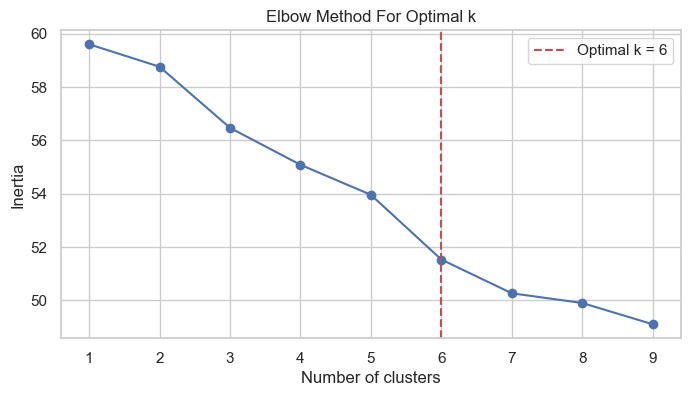

The optimal number of clusters is: 6


In [102]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Adjust parameters as necessary
X_tfidf = tfidf_vectorizer.fit_transform(opinionLeaders600['Text'])

# Now, apply the Elbow Method
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

# Find the "elbow" point
def find_elbow(inertia, K_range):
    # Calculate the slope between each point and the next
    slopes = np.diff(inertia)
    # Find the maximum change in slope
    optimal_k = np.argmax(np.diff(slopes)) + 2  # +2 because np.diff reduces the array size by 1 and we start from k=2
    return optimal_k

optimal_k = find_elbow(inertia, K_range)

# Plotting the inertia to find the elbow
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.axvline(x=optimal_k, color='r', linestyle='--', label=f'Optimal k = {optimal_k}')
plt.legend()
plt.show()

print(f"The optimal number of clusters is: {optimal_k}")


In [103]:
# Convert topic distributions to a DataFrame for easier manipulation
import numpy as np


# Prepare data for clustering - transform list of dictionary into matrix
topic_distribution_matrix = np.zeros((len(OL600_topic_matrix), optimal_num_topics_OL600))

for i, dist in enumerate(OL600_topic_matrix):
    for topic_num, prob in dist:
        topic_distribution_matrix[i, topic_num] = prob

# Apply K-Means Clustering on the topic distribution matrix
kmeans = KMeans(n_clusters=6, random_state=RANDOM_SEED)
clusters = kmeans.fit_predict(topic_distribution_matrix)

# Add the cluster labels to your original DataFrame
opinionLeaders600['Cluster'] = clusters

# Display the DataFrame with the new cluster column
print(opinionLeaders600[['Text', 'Cluster']].head())

                                                Text  Cluster
0  JAKARTA - Fiat recently revealed their latest ...        3
1  Customers asked for more crossovers, and Fiat ...        2
2  \nRelatively affordable to buy. Very useable 2...        0
3  4.0 out of 5 The ‘Frappuccino' of the small el...        0
4  There are two specifications available on the ...        0


In [104]:
# Calculate the mean topic distribution for each cluster
cluster_topic_distribution = np.zeros((6, optimal_num_topics_OL600))

for i in range(6):
    cluster_topic_distribution[i, :] = topic_distribution_matrix[opinionLeaders600['Cluster'] == i].mean(axis=0)

# Print the topic distribution for each cluster
for i in range(6):
    print(f"Cluster {i+1} topic distribution:")
    print(cluster_topic_distribution[i])
    print()

Cluster 1 topic distribution:
[0.69781334 0.07239914 0.05041726 0.03088337 0.05459453 0.08746638]

Cluster 2 topic distribution:
[0.06498597 0.68878497 0.07602688 0.03095378 0.06428095 0.06870802]

Cluster 3 topic distribution:
[0.05465094 0.0471804  0.809735   0.02272819 0.02280948 0.03516489]

Cluster 4 topic distribution:
[0.03111951 0.05952864 0.03303172 0.01818133 0.04057824 0.81029361]

Cluster 5 topic distribution:
[0.05511579 0.04684347 0.08730843 0.06228016 0.69367582 0.05374764]

Cluster 6 topic distribution:
[0.04759333 0.04790444 0.03952072 0.77716406 0.0245788  0.06080417]



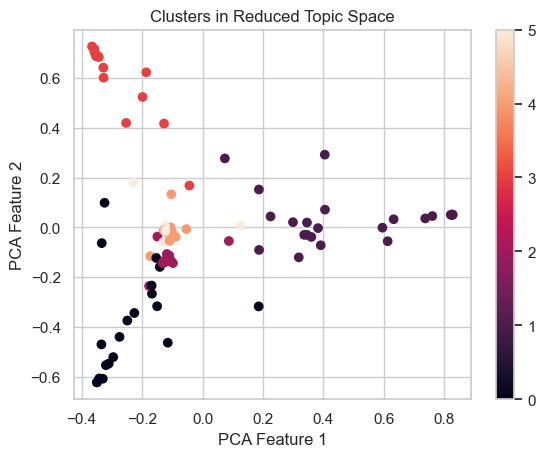

In [105]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(topic_distribution_matrix)

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters)
plt.title('Clusters in Reduced Topic Space')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar()
plt.show()


In [106]:


from collections import Counter
import random

# Number of sample articles to extract from each cluster
num_samples_per_cluster = 5

# Extract Sample Articles
sampled_articles = {}
for cluster in range(6):  
    cluster_articles = opinionLeaders600[opinionLeaders600['Cluster'] == cluster]['Text']
    sampled_articles[cluster] = cluster_articles.sample(min(num_samples_per_cluster, len(cluster_articles)), random_state=42).tolist()

# Summarize Common Themes
for cluster in range(6):
    print(f"Cluster {cluster + 1} Sample Articles:")
    for i, article in enumerate(sampled_articles[cluster]):
        print(f"Article {i + 1}: {article[:500]}...")  # Print the first 500 characters of each article
    print("\n")

# Keyword Analysis using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(opinionLeaders600['Text'])
feature_names = tfidf_vectorizer.get_feature_names_out()

for cluster in range(6):
    cluster_indices = opinionLeaders600[opinionLeaders600['Cluster'] == cluster].index
    cluster_tfidf = X_tfidf[cluster_indices]
    cluster_mean_tfidf = np.mean(cluster_tfidf, axis=0).A1
    keywords = [feature_names[i] for i in cluster_mean_tfidf.argsort()[-10:][::-1]]  # Top 10 keywords
    print(f"Cluster {cluster + 1} Top Keywords: {keywords}")

# Topic Distribution Analysis
for i in range(6):
    print(f"Cluster {i+1} topic distribution:")
    print(cluster_topic_distribution[i])
    print()



Cluster 1 Sample Articles:
Article 1: 
Relatively affordable to buy. Very useable 254-mile range. Top-spec La Prime is particularly well-equipped.
					 
Not as characterful as the little Fiat 500e. Surprising amount of road noise. We prefer the Jeep Avenger.
					 Like the look of the stylish Fiat 500e but need a little more space? The Fiat 600e is the car for you. It's a small electric SUV that's based on the same platform as the Jeep Avenger and Peugeot e-2008, while rivals include the Smart #1, Hyundai Kona Electric and MG ZS EV...
Article 2: Fiat is hoping to inject some 'La Dolce Vita' – the sweet life – into our motoring lives with its new all-electric 600e family crossover. We've driven the 600e EV to find out if it's worth the £33,000 outlay - or if you should hold tight for the hybrid to hit showrooms. Fiat's new electric family car: The 600e has arrived in the UK with enough range to take owners from London to Middlesbrough in one hit. But is the new EV too pricey for Briton

# Potential Customers 600e: Comments 600e

In [31]:
comments_600e_original = pd.read_csv(r'C:\Users\atani\OneDrive - City, University of London\Tanisha\ARP\600e - YouTube Comments_Emojis_Filtered.csv')
comments_600e = comments_600e_original.copy()
# Rename videoid to ID and Comment to Text
comments_600e.rename(columns={'VideoID': 'ID', 'Comment': 'Text'}, inplace=True)
comments_600e.head()

,Date,ID,Text
0,2024-03-08,AXGNb76QgH0,25000 is a fair price
1,2024-03-04,AXGNb76QgH0,it looks solid and i know its a great driving ...
2,2024-02-24,AXGNb76QgH0,really love the video and review of new fiat 6...
3,2024-02-16,AXGNb76QgH0,imagine if fiat invested in perfecting the 500...
4,2024-02-13,AXGNb76QgH0,my wife has a 500 c and all we love it nobody ...


In [32]:
len(comments_600e)

1161

In [33]:
print(comments_600e[comments_600e['ID'].isnull()])
print(comments_600e[comments_600e['Text'].isnull()])
print(comments_600e[comments_600e['Date'].isnull()])

Empty DataFrame
Columns: [Date, ID, Text]
Index: []
Empty DataFrame
Columns: [Date, ID, Text]
Index: []
Empty DataFrame
Columns: [Date, ID, Text]
Index: []


Optimal settings: 2 topics, Alpha: 0.1, Passes: 20, Coherence Score: 0.4879259084093248


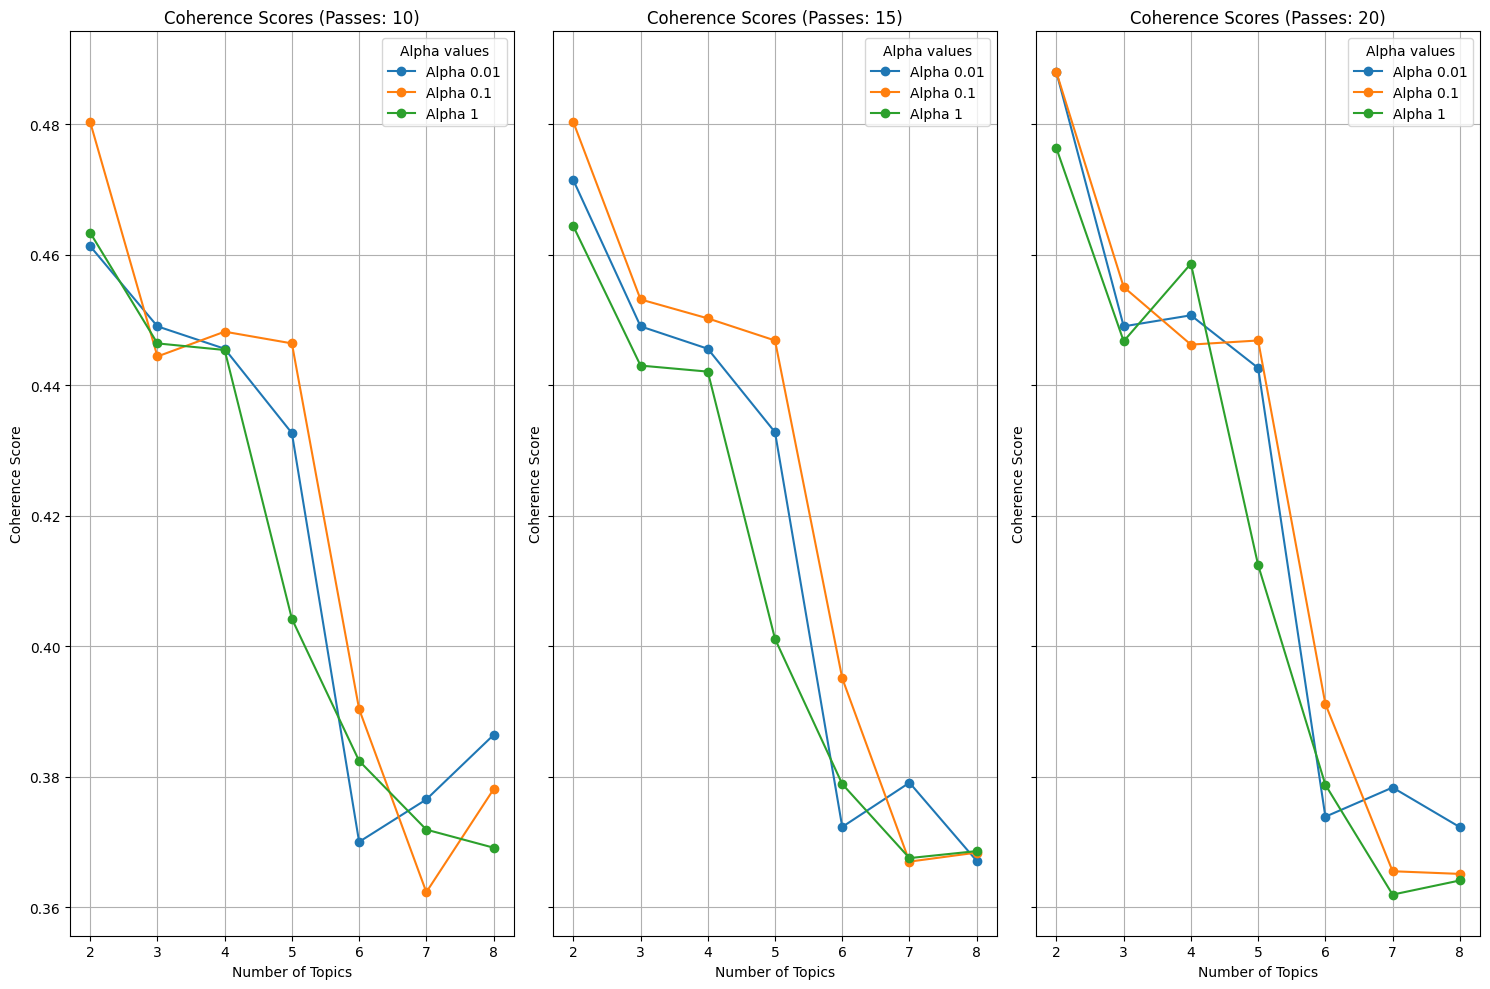

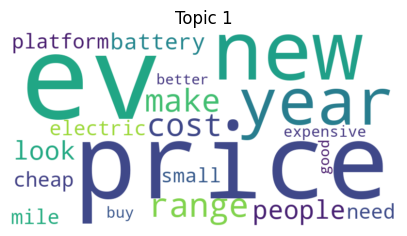

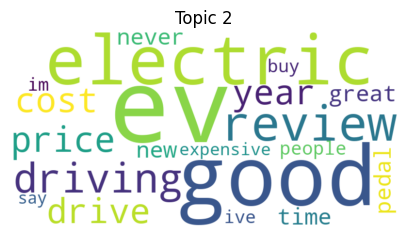

In [34]:
custom_stopwords = set(stopwords.words('english')).union({'car', 'cars', 
                             'black', 'grey', 'uh', 'yes', 'go', 'e', 'oh', 'still', 'chinese', 'ice', 'dont', 'doesnt', 'less',
                             'fiat', 'jeep', 'avenger', 'abarth', 'stellantis', 'hyundai', 'honda', 'kona','kind', 'want', 'mean', 'fat','um', 'yeah', 'okay',
                             'one', 'content', 'information', 'interests', 'activity', 'notice', 'also', 'would', 'going', 'be', 'much', 'comes',
                             'like', 'bit', 'quite', 'lot', 'well', 'really', 'get', 'got', 'little', 'feeling', 'think', 'actually',
                             'even', 'however', 'around', 'see', 'know',
                             'presented', 'example'  
})
    

# Processing the documents
processed_docs = [preprocess(doc) for doc in comments_600e['Text']]
dictionary = corpora.Dictionary(processed_docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Compute models and coherence
num_topics_range = range(2, 9)
alpha_range = [0.01, 0.1,  1]
passes_range = range(10, 21, 5)
model_list, coherence_results = compute_coherence_values(dictionary, bow_corpus, processed_docs, num_topics_range, alpha_range, passes_range)

# Finding and displaying the best model
optimal_result_pc600 = max(coherence_results, key=lambda x: x['coherence'])
print(f"Optimal settings: {optimal_result_pc600['num_topics']} topics, Alpha: {optimal_result_pc600['alpha']}, Passes: {optimal_result_pc600['passes']}, Coherence Score: {optimal_result_pc600['coherence']}")

# Assuming `coherence_results` is your list of dictionaries containing the coherence data
plot_coherence_scores(coherence_results)

# Visualize topics using word clouds
optimal_model_pc600 = optimal_result_pc600['model']
optimal_num_topics_pc600 = optimal_result_pc600['num_topics']
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white', stopwords=custom_stopwords, random_state=RANDOM_SEED)
for i in range(optimal_num_topics_pc600):
    plt.figure(figsize=(5, 4))
    topic_words = dict(optimal_model_pc600.show_topic(i, 20))
    filtered_words = {word: freq for word, freq in topic_words.items() if word not in custom_stopwords}
    plt.imshow(wordcloud.generate_from_frequencies(filtered_words), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {i + 1}")
    plt.show()

In [35]:
lda_pc600 = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=optimal_num_topics_pc600, alpha=optimal_result_pc600['alpha'], passes=optimal_result_pc600['passes'], random_state=RANDOM_SEED)

In [36]:
for idx, topic in lda_pc600.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.017*"ev" + 0.013*"price" + 0.008*"new" + 0.007*"year" + 0.006*"range" + 0.006*"make" + 0.006*"cost" + 0.005*"people" + 0.005*"look" + 0.005*"battery"
Topic: 1 
Words: 0.009*"ev" + 0.007*"good" + 0.006*"electric" + 0.005*"review" + 0.005*"driving" + 0.004*"price" + 0.004*"drive" + 0.004*"cost" + 0.004*"year" + 0.004*"great"


In [37]:
# Visualise topics using pyLDAvis
pc600_vis = gensimvis.prepare(lda_pc600, bow_corpus, dictionary, sort_topics=False)  # Ensure reproducibility by setting sort_topics to False
pyLDAvis.display(pc600_vis)

In [38]:
# Get the topic distribution for each document
pc600_topic_matrix = [lda_pc600[doc] for doc in bow_corpus]

# Extract topic probabilities and add them as columns
comments_600e['Topic 1'] = [dict(doc).get(0, 0) for doc in pc600_topic_matrix]
comments_600e['Topic 2'] = [dict(doc).get(1, 0) for doc in pc600_topic_matrix]

# Display the table with the new topic columns
comments_600e.head()

,Date,ID,Text,Topic 1,Topic 2
0,2024-03-08,AXGNb76QgH0,25000 is a fair price,0.954536,0.045465
1,2024-03-04,AXGNb76QgH0,it looks solid and i know its a great driving ...,0.980760,0.019240
2,2024-02-24,AXGNb76QgH0,really love the video and review of new fiat 6...,0.000000,0.991801
3,2024-02-16,AXGNb76QgH0,imagine if fiat invested in perfecting the 500...,0.996793,0.000000
4,2024-02-13,AXGNb76QgH0,my wife has a 500 c and all we love it nobody ...,0.000000,0.994501


In [39]:
# Apply sentiment analysis to each document
comments_600e['Sentiment'] = comments_600e['Text'].apply(get_sentiment)

# Determine the primary topic for each document
comments_600e['Primary_Topic'] = comments_600e[['Topic 1', 'Topic 2']].idxmax(axis=1)

# Calculate mean sentiment for each topic
topic_sentiment = comments_600e.groupby('Primary_Topic')['Sentiment'].mean()

print(topic_sentiment)


# Calculate mean sentiment for each topic monthly
comments_600e['Date'] = pd.to_datetime(comments_600e['Date'])
comments_600e['Month'] = comments_600e['Date'].dt.to_period('M')
monthly_topic_sentiment = comments_600e.groupby(['Primary_Topic', 'Month'])['Sentiment'].mean()
# Print per month, not per topic
monthly_topic_sentiment = comments_600e.pivot_table(index='Month', columns='Primary_Topic', values='Sentiment', aggfunc='mean')
print(monthly_topic_sentiment)

Primary_Topic
Topic 1    0.096348
Topic 2    0.132811
Name: Sentiment, dtype: float64
Primary_Topic   Topic 1   Topic 2
Month                            
2023-06        0.000000  0.062937
2023-07             NaN  0.257540
2023-09        0.089978  0.115894
2023-10        0.076803  0.125282
2023-11        0.136240  0.142494
2023-12        0.026111 -0.210606
2024-01        0.071588       NaN
2024-02        0.305652  0.206618
2024-03        0.147227  0.182619
2024-04        0.165911  0.292643
2024-05       -0.387500 -0.148836


In [40]:
# Check the proportion of negative sentiment articles
negative_sentiment = comments_600e[comments_600e['Sentiment'] < 0]
print(len(negative_sentiment)/len(comments_600e))
print(len(negative_sentiment))

# Check the proportion of negative sentiment articles per topic
negative_sentiment_per_topic = negative_sentiment.groupby('Primary_Topic').size()
total_articles_per_topic = comments_600e.groupby('Primary_Topic').size()
negative_sentiment_proportion_per_topic = negative_sentiment_per_topic / total_articles_per_topic
print(negative_sentiment_proportion_per_topic)

# Check the proportion of negative sentiment articles per month
negative_sentiment['Month'] = negative_sentiment['Date'].dt.to_period('M')
negative_sentiment_per_month = negative_sentiment.groupby('Month').size()
total_articles_per_month = comments_600e.groupby('Month').size()
negative_sentiment_proportion_per_month = negative_sentiment_per_month / total_articles_per_month
print(negative_sentiment_proportion_per_month)

0.2127476313522825
247
Primary_Topic
Topic 1    0.237003
Topic 2    0.181460
dtype: float64
Month
2023-06    0.300000
2023-07    0.333333
2023-09    0.222964
2023-10    0.210526
2023-11    0.135135
2023-12    0.333333
2024-01    0.333333
2024-02    0.066667
2024-03    0.159091
2024-04    0.151515
2024-05    0.714286
Freq: M, dtype: float64


C:\Users\atani\AppData\Local\Temp\ipykernel_13016\3102474647.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_sentiment['Month'] = negative_sentiment['Date'].dt.to_period('M')


# Clustering Analysis

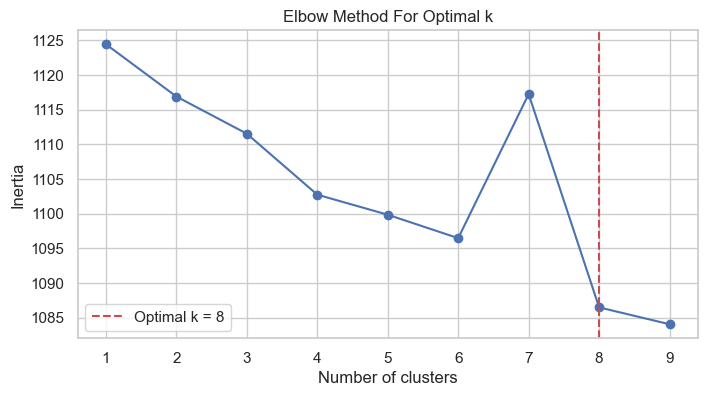

The optimal number of clusters based on the Elbow Method is: 8
                                                Text  Cluster
0                              25000 is a fair price        6
1  it looks solid and i know its a great driving ...        7
2  really love the video and review of new fiat 6...        4
3  imagine if fiat invested in perfecting the 500...        3
4  my wife has a 500 c and all we love it nobody ...        4


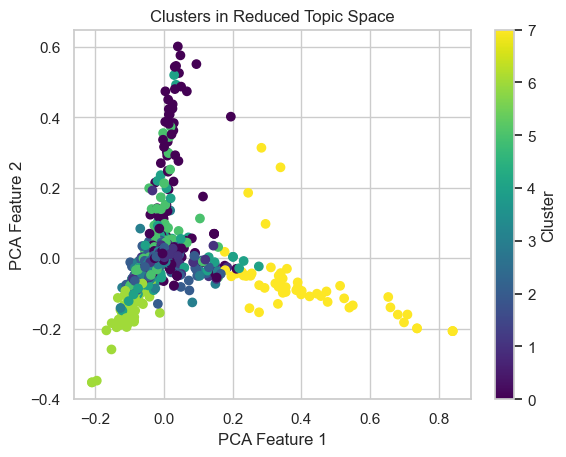

Cluster 1 Sample Comments:
Comment 1: gives you an evil eye...
Comment 2: stellantis gehört die zukunft und allen ihren marken ...
Comment 3: fiat shouldve done a 500e giardinia  estate and this 600e shouldve been a multipla...
Comment 4: no its completely different and unrelated car mechanically is closer to mokka or 2008 than to 500x...
Comment 5: fun  seriously there is nothing fun about this car unless we have very different view what is fun...


Cluster 2 Sample Comments:
Comment 1: 33000 pounds is one heavy car what the frunk...
Comment 2: why shouldnt the fiat have an engine an electric machine is also a motor but also a generator  the difference lies in the direction of energy conversion in the generator the rotor is driven mechanically and thereby generates electrical energy in the windings of the stator with a motor the same machine is supplied with electrical energy and thereby generates mechanical energy

i like the 600 and i dont need 70 or 100 kwh batteries in the car vis

In [107]:

# Rename columns
comments_600e.rename(columns={'VideoID': 'ID', 'Comment': 'Text'}, inplace=True)

# Custom stopwords
custom_stopwords = set(stopwords.words('english')).union({'car', 'cars', 
                             'black', 'grey', 'uh', 'yes', 'go', 'e', 'oh', 'still', 'chinese', 'ice', 'dont', 'doesnt', 'less',
                             'fiat', 'jeep', 'avenger', 'abarth', 'stellantis', 'hyundai', 'honda', 'kona','kind', 'want', 'mean', 'fat','um', 'yeah', 'okay',
                             'one', 'content', 'information', 'interests', 'activity', 'notice', 'also', 'would', 'going', 'be', 'much', 'comes',
                             'like', 'bit', 'quite', 'lot', 'well', 'really', 'get', 'got', 'little', 'feeling', 'think', 'actually',
                             'even', 'however', 'around', 'see', 'know',
                             'presented', 'example'})

# Preprocess function
def preprocess(text):
    if isinstance(text, str):
        text = re.sub(r'\b\w{1,2}\b', '', text)  # Remove short words
        tokens = nltk.word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalpha() and word not in custom_stopwords]
        return tokens
    else:
        return []

# Processing the documents
processed_docs = [" ".join(preprocess(doc)) for doc in comments_600e['Text']]

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=list(custom_stopwords))  # Convert stopwords to list
X_tfidf = tfidf_vectorizer.fit_transform(processed_docs)

# Apply the Elbow Method
inertia = []
K_range = range(1, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

# Find the "elbow" point
def find_elbow(inertia, K_range):
    slopes = np.diff(inertia)
    optimal_k = np.argmax(np.diff(slopes)) + 2  # +2 because np.diff reduces the array size by 1 and we start from k=2
    return optimal_k

optimal_k_elbow = find_elbow(inertia, K_range)

# Plotting the inertia to find the elbow
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.axvline(x=optimal_k_elbow, color='r', linestyle='--', label=f'Optimal k = {optimal_k_elbow}')
plt.legend()
plt.show()

print(f"The optimal number of clusters based on the Elbow Method is: {optimal_k_elbow}")

# Apply K-Means Clustering on the TF-IDF matrix
kmeans = KMeans(n_clusters=optimal_k_elbow, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# Add the cluster labels to your original DataFrame
comments_600e['Cluster'] = clusters

# Display the DataFrame with the new cluster column
print(comments_600e[['Text', 'Cluster']].head())

# Plotting cluster results using PCA for visualization
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X_tfidf.toarray())

plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=clusters, cmap='viridis')
plt.title('Clusters in Reduced Topic Space')
plt.xlabel('PCA Feature 1')
plt.ylabel('PCA Feature 2')
plt.colorbar(label='Cluster')
plt.show()

# Extract Sample Comments
num_samples_per_cluster = 5
sampled_comments = {}
for cluster in range(optimal_k_elbow):
    cluster_comments = comments_600e[comments_600e['Cluster'] == cluster]['Text']
    if len(cluster_comments) > 0:  # Check if there are any comments in the cluster
        sampled_comments[cluster] = cluster_comments.sample(min(num_samples_per_cluster, len(cluster_comments)), random_state=42).tolist()

# Summarize Common Themes
for cluster in range(optimal_k_elbow):
    print(f"Cluster {cluster + 1} Sample Comments:")
    if cluster in sampled_comments:  # Check if the cluster has any sampled comments
        for i, comment in enumerate(sampled_comments[cluster]):
            print(f"Comment {i + 1}: {comment[:500]}...")  # Print the first 100 characters of each comment
    print("\n")

# Keyword Analysis using TF-IDF
feature_names = tfidf_vectorizer.get_feature_names_out()
for cluster in range(optimal_k_elbow):
    cluster_indices = comments_600e[comments_600e['Cluster'] == cluster].index
    if len(cluster_indices) > 0:  # Check if there are any indices in the cluster
        cluster_tfidf = X_tfidf[cluster_indices]
        cluster_mean_tfidf = np.mean(cluster_tfidf, axis=0).A1
        if len(cluster_mean_tfidf) > 0:  # Check if the cluster_mean_tfidf array is not empty
            keywords = [feature_names[i] for i in cluster_mean_tfidf.argsort()[-10:][::-1]]  # Top 10 keywords
            print(f"Cluster {cluster + 1} Top Keywords: {keywords}")


# Potential Customers 500e: Comments 500e

In [41]:
comments_500e_original = pd.read_csv(r'C:\Users\atani\OneDrive - City, University of London\Tanisha\ARP\500e - YouTube Comments_Emojis_Filtered.csv')
comments_500e = comments_500e_original.copy()
# Rename videoid to ID and Comment to Text
comments_500e.rename(columns={'VideoID': 'ID', 'Comment': 'Text'}, inplace=True)
comments_500e.head()

,Date,ID,Text
0,2024-05-04,0kDbvxpjLZs,9 seconds for an electric car thats especially...
1,2024-02-16,0kDbvxpjLZs,good honest review thanks like the car im i...
2,2024-01-06,0kDbvxpjLZs,this is a genius car this is a car that you do...
3,2023-10-21,0kDbvxpjLZs,got a twinair mito done 60k in it its great ...
4,2023-09-16,0kDbvxpjLZs,no spare wheel is a dealbreaker i love that ga...


In [42]:
len(comments_500e)

2564

In [43]:
print(comments_500e[comments_500e['ID'].isnull()])
print(comments_500e[comments_500e['Text'].isnull()])
print(comments_500e[comments_500e['Date'].isnull()])

Empty DataFrame
Columns: [Date, ID, Text]
Index: []
Empty DataFrame
Columns: [Date, ID, Text]
Index: []
Empty DataFrame
Columns: [Date, ID, Text]
Index: []


Optimal settings: 3 topics, Alpha: 0.1, Passes: 20, Coherence Score: 0.5619771994074622


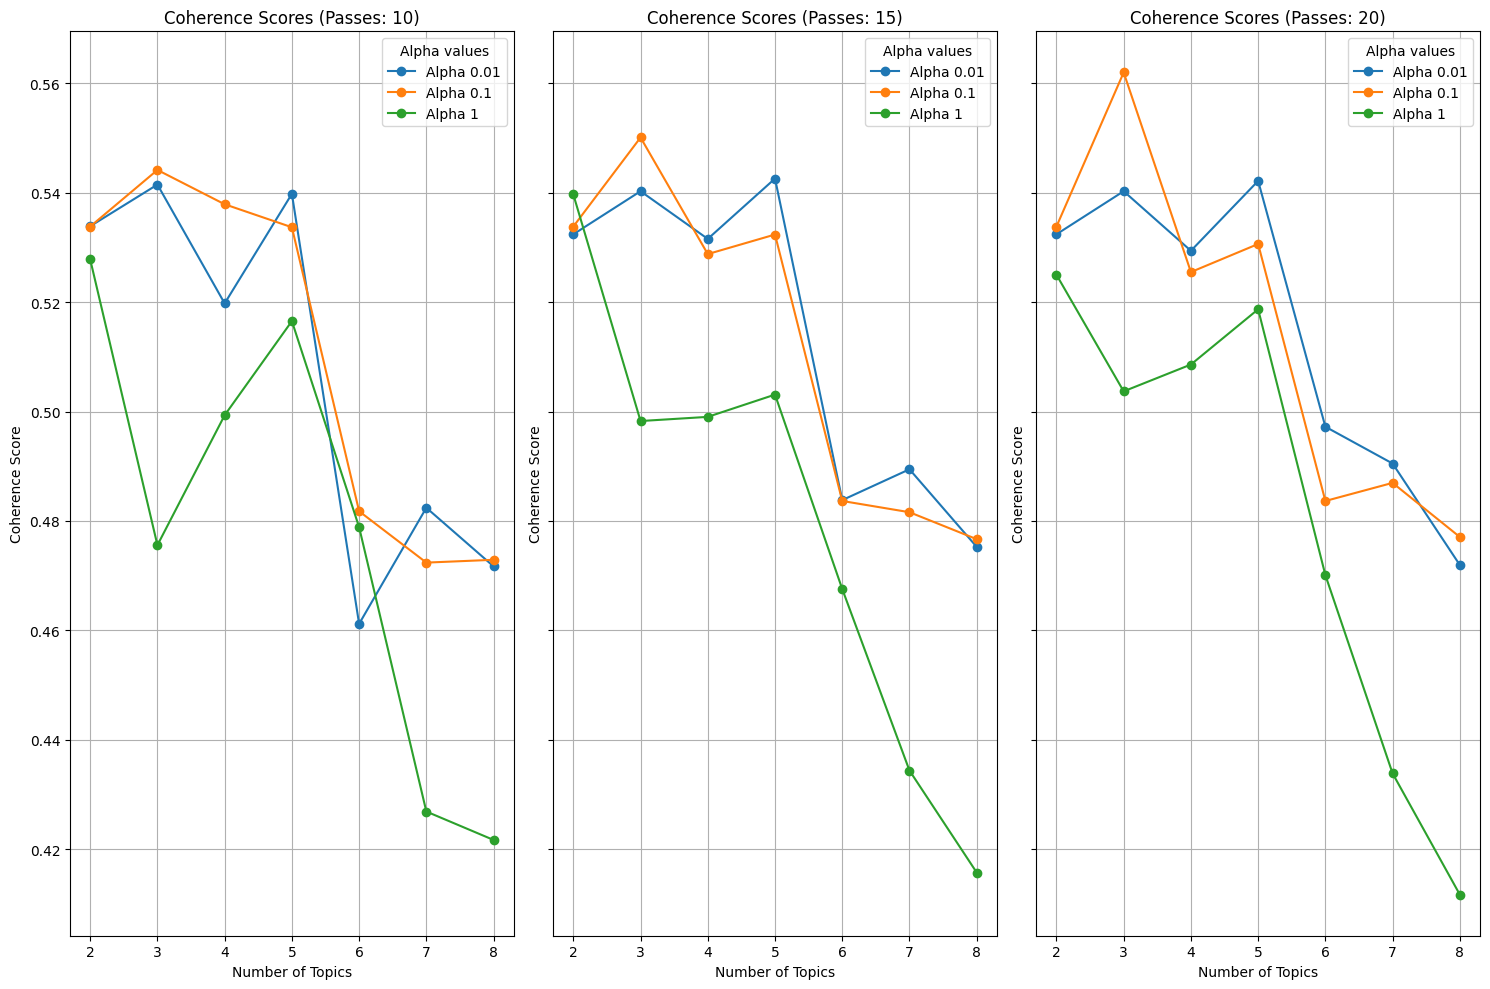

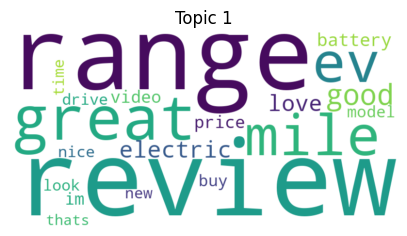

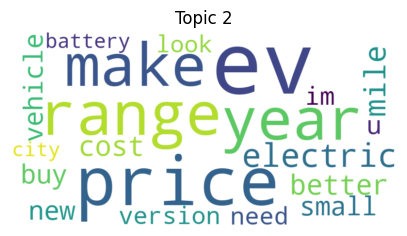

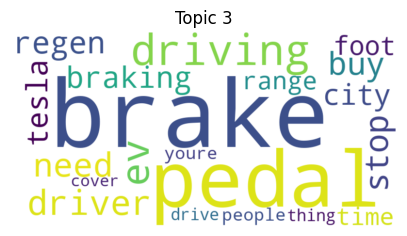

In [44]:
custom_stopwords = set(stopwords.words('english')).union({'car', 'cars', 
                             'black', 'grey', 'uh', 'yes', 'go', 'e', 'oh', 'still', 'chinese', 'ice', 'dont', 'doesnt', 'less',
                             'fiat', 'jeep', 'avenger', 'abarth', 'stellantis', 'hyundai', 'honda', 'kona','kind', 'want', 'mean', 'fat','um', 'yeah', 'okay',
                             'one', 'content', 'information', 'interests', 'activity', 'notice', 'also', 'would', 'going', 'be', 'much', 'comes',
                             'like', 'bit', 'quite', 'lot', 'well', 'really', 'get', 'got', 'little', 'feeling', 'think', 'actually',
                             'even', 'however', 'around', 'see', 'know',
                             'presented', 'example'
})


# Processing the documents
processed_docs = [preprocess(doc) for doc in comments_500e['Text']]
dictionary = corpora.Dictionary(processed_docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Compute models and coherence
num_topics_range = range(2, 9)
alpha_range = [0.01, 0.1,  1]
passes_range = range(10, 21, 5)
model_list, coherence_results = compute_coherence_values(dictionary, bow_corpus, processed_docs, num_topics_range, alpha_range, passes_range)

# Finding and displaying the best model
optimal_result_pc500 = max(coherence_results, key=lambda x: x['coherence'])
print(f"Optimal settings: {optimal_result_pc500['num_topics']} topics, Alpha: {optimal_result_pc500['alpha']}, Passes: {optimal_result_pc500['passes']}, Coherence Score: {optimal_result_pc500['coherence']}")

# Assuming `coherence_results` is your list of dictionaries containing the coherence data
plot_coherence_scores(coherence_results)

# Visualize topics using word clouds
optimal_model_pc500 = optimal_result_pc500['model']
optimal_num_topics_pc500 = optimal_result_pc500['num_topics']
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white', stopwords=custom_stopwords, random_state=RANDOM_SEED)
for i in range(optimal_num_topics_pc500):
    plt.figure(figsize=(5, 4))
    topic_words = dict(optimal_model_pc500.show_topic(i, 20))
    filtered_words = {word: freq for word, freq in topic_words.items() if word not in custom_stopwords}
    plt.imshow(wordcloud.generate_from_frequencies(filtered_words), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {i + 1}")
    plt.show()

In [45]:
lda_pc500 = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=optimal_num_topics_pc500, alpha=optimal_result_pc500['alpha'], passes=optimal_result_pc500['passes'], random_state=RANDOM_SEED)

In [46]:
for idx, topic in lda_pc500.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.014*"review" + 0.013*"range" + 0.011*"great" + 0.009*"mile" + 0.009*"ev" + 0.008*"good" + 0.007*"electric" + 0.007*"love" + 0.006*"battery" + 0.006*"video"
Topic: 1 
Words: 0.019*"ev" + 0.011*"price" + 0.009*"range" + 0.008*"make" + 0.008*"year" + 0.008*"electric" + 0.007*"mile" + 0.006*"cost" + 0.006*"better" + 0.005*"small"
Topic: 2 
Words: 0.017*"brake" + 0.013*"pedal" + 0.011*"driving" + 0.009*"ev" + 0.007*"driver" + 0.006*"need" + 0.006*"stop" + 0.006*"buy" + 0.005*"regen" + 0.005*"braking"


In [47]:
# Visualise topics using pyLDAvis
pc500_vis = gensimvis.prepare(lda_pc500, bow_corpus, dictionary, sort_topics=False)  # Ensure reproducibility by setting sort_topics to False
pyLDAvis.display(pc500_vis)

In [48]:
# Get the topic distribution for each document
pc500_topic_matrix = [lda_pc500[doc] for doc in bow_corpus]

# Extract topic probabilities and add them as columns
comments_500e['Topic 1'] = [dict(doc).get(0, 0) for doc in pc500_topic_matrix]
comments_500e['Topic 2'] = [dict(doc).get(1, 0) for doc in pc500_topic_matrix]
comments_500e['Topic 3'] = [dict(doc).get(2, 0) for doc in pc500_topic_matrix]

# Display the table with the new topic columns
comments_500e.head()

,Date,ID,Text,Topic 1,Topic 2,Topic 3
0,2024-05-04,0kDbvxpjLZs,9 seconds for an electric car thats especially...,0.962240,0.018880,0.018879
1,2024-02-16,0kDbvxpjLZs,good honest review thanks like the car im i...,0.980578,0.000000,0.000000
2,2024-01-06,0kDbvxpjLZs,this is a genius car this is a car that you do...,0.023271,0.599759,0.376970
3,2023-10-21,0kDbvxpjLZs,got a twinair mito done 60k in it its great ...,0.993986,0.000000,0.000000
4,2023-09-16,0kDbvxpjLZs,no spare wheel is a dealbreaker i love that ga...,0.000000,0.687613,0.306597


In [49]:
# Apply sentiment analysis to each document
comments_500e['Sentiment'] = comments_500e['Text'].apply(get_sentiment)

# Determine the primary topic for each document
comments_500e['Primary_Topic'] = comments_500e[['Topic 1', 'Topic 2', 'Topic 3']].idxmax(axis=1)

# Calculate mean sentiment for each topic
topic_sentiment = comments_500e.groupby('Primary_Topic')['Sentiment'].mean()

print(topic_sentiment)


# Calculate mean sentiment for each topic monthly
comments_500e['Date'] = pd.to_datetime(comments_500e['Date'])
comments_500e['Month'] = comments_500e['Date'].dt.to_period('M')
monthly_topic_sentiment = comments_500e.groupby(['Primary_Topic', 'Month'])['Sentiment'].mean()
# Print per month, not per topic
monthly_topic_sentiment = comments_500e.pivot_table(index='Month', columns='Primary_Topic', values='Sentiment', aggfunc='mean')
print(monthly_topic_sentiment)

Primary_Topic
Topic 1    0.202966
Topic 2    0.111555
Topic 3    0.102476
Name: Sentiment, dtype: float64
Primary_Topic   Topic 1   Topic 2   Topic 3
Month                                      
2020-12        0.257044  0.141189  0.106146
2021-01        0.392858  0.020833  0.225000
2021-02        0.269500 -0.033333       NaN
2021-03        0.320758  0.150000       NaN
2021-04        0.212535  0.117361  0.175000
2021-05        0.190319  0.226004  0.144115
2021-06        0.204256  0.080836  0.151327
2021-07        0.147123  0.140543 -0.007143
2021-08        0.189286  0.054098  0.093667
2021-09        0.093723  0.302083  0.130556
2021-10        0.081779 -0.163889 -0.083333
2021-11        0.345833  0.459722  0.181250
2021-12       -0.125425  0.111095  0.083333
2022-01        0.002093  0.075000  0.000000
2022-02        0.319042  0.128286  0.101970
2022-03        0.137698  0.344167  0.209296
2022-04        0.186753  0.007263  0.000000
2022-05        0.123646  0.316818 -0.147500
2022-06       

In [50]:
# Check the proportion of negative sentiment articles
negative_sentiment = comments_500e[comments_500e['Sentiment'] < 0]
print(len(negative_sentiment)/len(comments_500e))
print(len(negative_sentiment))

# Check the proportion of negative sentiment articles per topic
negative_sentiment_per_topic = negative_sentiment.groupby('Primary_Topic').size()
total_articles_per_topic = comments_500e.groupby('Primary_Topic').size()
negative_sentiment_proportion_per_topic = negative_sentiment_per_topic / total_articles_per_topic
print(negative_sentiment_proportion_per_topic)

# Check the proportion of negative sentiment articles per month
negative_sentiment['Month'] = negative_sentiment['Date'].dt.to_period('M')
negative_sentiment_per_month = negative_sentiment.groupby('Month').size()
total_articles_per_month = comments_500e.groupby('Month').size()
negative_sentiment_proportion_per_month = negative_sentiment_per_month / total_articles_per_month
print(negative_sentiment_proportion_per_month)

0.1731669266770671
444
Primary_Topic
Topic 1    0.157303
Topic 2    0.188634
Topic 3    0.194030
dtype: float64
Month
2020-12    0.152698
2021-01         NaN
2021-02    0.100000
2021-03         NaN
2021-04         NaN
2021-05    0.092593
2021-06    0.217143
2021-07    0.250000
2021-08    0.187500
2021-09    0.250000
2021-10    0.454545
2021-11         NaN
2021-12    0.222222
2022-01    0.375000
2022-02    0.126984
2022-03    0.200000
2022-04    0.200000
2022-05    0.307692
2022-06         NaN
2022-07    0.285714
2022-08    0.125000
2022-09         NaN
2022-10    0.142857
2022-11    0.166227
2022-12    0.207921
2023-01    0.142857
2023-02         NaN
2023-03    0.333333
2023-04         NaN
2023-05    0.333333
2023-06    0.111111
2023-07         NaN
2023-08    0.230769
2023-09    0.217391
2023-10         NaN
2023-11    0.166667
2023-12    0.083333
2024-01    0.181818
2024-02    0.500000
2024-03    0.117647
2024-04    0.151786
2024-05    0.209150
2024-06    0.222222
Freq: M, dtype: float6

C:\Users\atani\AppData\Local\Temp\ipykernel_13016\1204473181.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_sentiment['Month'] = negative_sentiment['Date'].dt.to_period('M')


# Clustering Analysis

Empty DataFrame
Columns: [Date, ID, Text]
Index: []
Empty DataFrame
Columns: [Date, ID, Text]
Index: []
Empty DataFrame
Columns: [Date, ID, Text]
Index: []


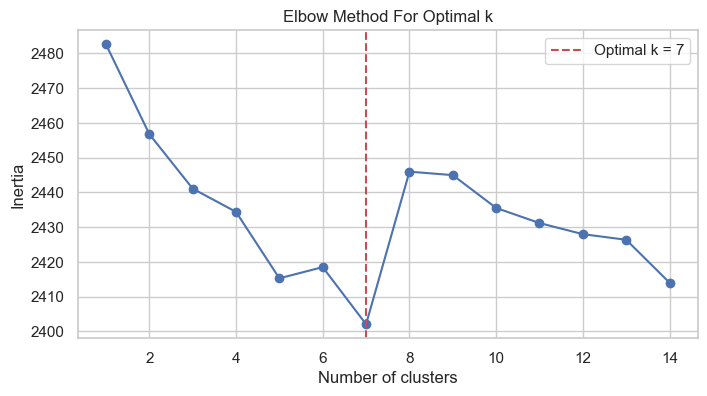

The optimal number of clusters based on the Elbow Method is: 7


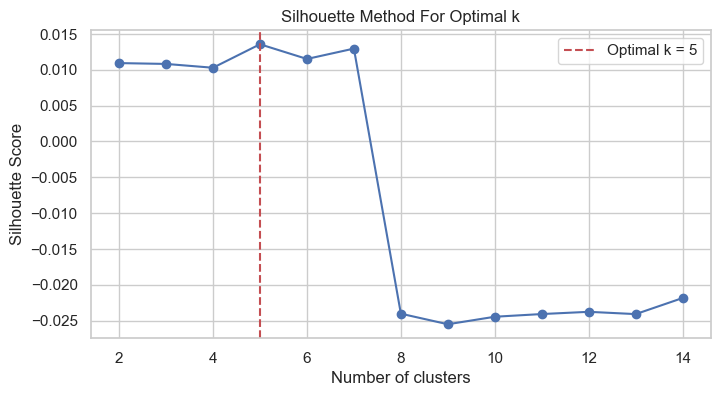

The optimal number of clusters based on the Silhouette Method is: 5


In [116]:
# Preprocess function
def preprocess(text):
    if isinstance(text, str):
        text = re.sub(r'\b\w{1,2}\b', '', text)  # Remove short words
        tokens = nltk.word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalpha() and word not in custom_stopwords]
        return ' '.join(tokens)  # Return processed text as a string
    else:
        return ''

# Custom stopwords
custom_stopwords = set(stopwords.words('english')).union({
    'car', 'cars', 'black', 'grey', 'uh', 'yes', 'go', 'e', 'oh', 'still', 'chinese', 
    'ice', 'dont', 'doesnt', 'less', 'fiat', 'jeep', 'avenger', 'abarth', 'stellantis', 
    'hyundai', 'honda', 'kona', 'kind', 'want', 'mean', 'fat', 'um', 'yeah', 'okay', 
    'one', 'content', 'information', 'interests', 'activity', 'notice', 'also', 'would', 
    'going', 'be', 'much', 'comes', 'like', 'bit', 'quite', 'lot', 'well', 'really', 
    'get', 'got', 'little', 'feeling', 'think', 'actually', 'even', 'however', 'around', 
    'see', 'know', 'presented', 'example'
})

# Load the dataset
comments_500e_original = pd.read_csv(r'C:\Users\atani\OneDrive - City, University of London\Tanisha\ARP\500e - YouTube Comments_Emojis_Filtered.csv')
comments_500e = comments_500e_original.copy()

# Rename columns
comments_500e.rename(columns={'VideoID': 'ID', 'Comment': 'Text'}, inplace=True)

# Check for missing values
print(comments_500e[comments_500e['ID'].isnull()])
print(comments_500e[comments_500e['Text'].isnull()])
print(comments_500e[comments_500e['Date'].isnull()])

# Process the documents
processed_docs = [preprocess(doc) for doc in comments_500e['Text']]

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=list(custom_stopwords))
X_tfidf = tfidf_vectorizer.fit_transform(processed_docs)

# Apply the Elbow Method to determine the optimal number of clusters
inertia = []
K_range = range(1, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

# Find the "elbow" point
def find_elbow(inertia, K_range):
    slopes = np.diff(inertia)
    optimal_k = np.argmax(np.diff(slopes)) + 2  # +2 because np.diff reduces the array size by 1 and we start from k=2
    return optimal_k

optimal_k_elbow = find_elbow(inertia, K_range)

# Plotting the inertia to find the elbow
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.axvline(x=optimal_k_elbow, color='r', linestyle='--', label=f'Optimal k = {optimal_k_elbow}')
plt.legend()
plt.show()

print(f"The optimal number of clusters based on the Elbow Method is: {optimal_k_elbow}")

# Apply the Silhouette Method
silhouette_scores = []

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    silhouette_scores.append(silhouette_score(X_tfidf, kmeans.labels_))

optimal_k_silhouette = np.argmax(silhouette_scores) + 2  # +2 because the range starts from 2

# Plotting the silhouette scores to find the optimal number of clusters
plt.figure(figsize=(8, 4))
plt.plot(range(2, 15), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.axvline(x=optimal_k_silhouette, color='r', linestyle='--', label=f'Optimal k = {optimal_k_silhouette}')
plt.legend()
plt.show()

print(f"The optimal number of clusters based on the Silhouette Method is: {optimal_k_silhouette}")

# Decide on the optimal number of clusters
optimal_k = max(optimal_k_elbow, optimal_k_silhouette)  # Choose the higher number for better separation

Cluster 1 samples:
- we had one of the first primas in the country owned it for about 18 months 
my wife loves it i still have my 2017 passat dinosaur burner for work but in town this thing is my first choice over the vw ...
- im sure there will be a menu to change the rear wiper from mirroring to not linked also the step of intermittent time i had a corsa d that had menus to customise and the corsa d is a punto basically...
- pisses me off that they wont be bringing this to the us  damn shame  hey fiat  bring it over...


Cluster 2 samples:
- i vowed as a teenager that id never own another fiat after several painful years with my disastrous 124 sport coupe which was more rust than steel at the end my favorite part of the video is mendelsso...
- looking really smart jonny i was waiting for your review of this car and as with the many others you have done its a good one...
- best review online jonny  love the onscreen info panels also the range comparison with the rival cars makes loads

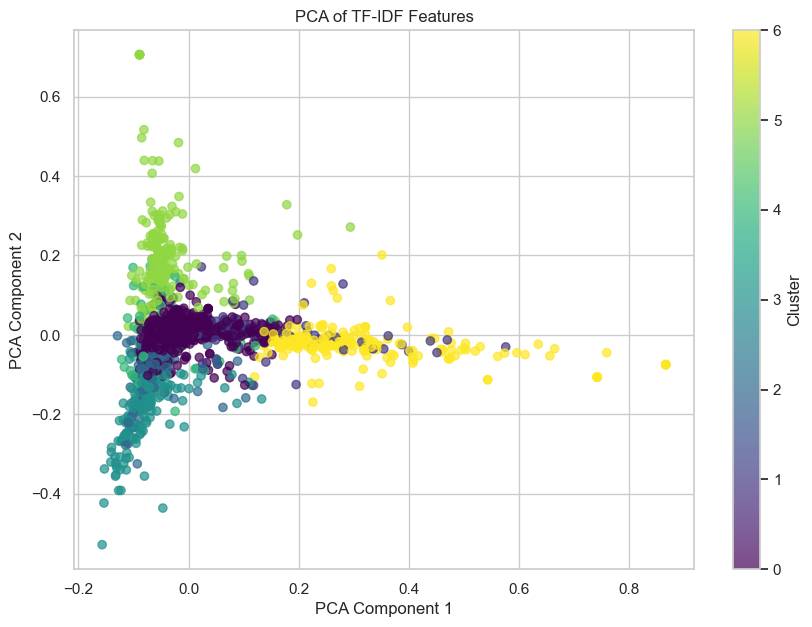

Cluster 1 Top Keywords: love, buy, drive, nice, evs, good, battery, thats, driving, time

Cluster 2 Top Keywords: jonny, review, great, nice, excellent, production, watch, good, always, love

Cluster 3 Top Keywords: price, range, buy, used, high, could, good, small, tag, evs

Cluster 4 Top Keywords: range, miles, mile, better, model, could, need, charge, long, price

Cluster 5 Top Keywords: version, petrol, cost, battery, old, electric, range, back, new, need

Cluster 6 Top Keywords: electric, vehicles, new, small, drive, vehicle, time, used, great, italian

Cluster 7 Top Keywords: review, great, love, thanks, good, thank, johnny, best, channel, video



In [119]:
# Apply K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# Add cluster labels to the DataFrame
comments_500e['Cluster'] = clusters

# Print samples from each cluster
for cluster in range(optimal_k):
    print(f"Cluster {cluster + 1} samples:")
    samples = comments_500e[comments_500e['Cluster'] == cluster].sample(3, random_state=42)
    for index, row in samples.iterrows():
        print(f"- {row['Text'][:200]}...")  # Print the first 200 characters of each sample
    print("\n")

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of TF-IDF Features')
plt.show()

# Keyword Analysis for Each Cluster
feature_names = tfidf_vectorizer.get_feature_names_out()

for cluster in range(optimal_k):
    cluster_tfidf = X_tfidf[clusters == cluster]
    cluster_mean_tfidf = np.mean(cluster_tfidf, axis=0)
    
    if cluster_tfidf.shape[0] > 0:  # Check if the cluster_tfidf matrix is not empty
        # Ensure cluster_mean_tfidf is a 1D array
        cluster_mean_tfidf = np.array(cluster_mean_tfidf).flatten()
        
        # Get indices of top 10 features
        top_indices = np.argsort(cluster_mean_tfidf)[-10:][::-1]
        
        # Get top 10 keywords
        top_keywords = [feature_names[i] for i in top_indices]
        
        print(f"Cluster {cluster + 1} Top Keywords: {', '.join(top_keywords)}\n")

# Real Customers 500e: Forums SpeakEV & PistonHead

In [51]:
forums_500e_original = pd.read_csv(r'C:\Users\atani\OneDrive - City, University of London\Tanisha\ARP\500e - Forums_Merged_20240724.csv')
forums_500e = forums_500e_original.copy()
# Rename Content to Text and add ID column
forums_500e['ID'] = forums_500e.index
forums_500e.rename(columns={'Content': 'Text'}, inplace=True)
forums_500e.head()

,Date,URL,Text,ID
0,2023-07-21,https://www.speakev.com/threads/fiat-500e-icon...,we will receive our new fiat 500e icon 2 month...,0
1,2023-07-21,https://www.speakev.com/threads/fiat-500e-icon...,do i need a home ev charger or can it be plugg...,1
2,2023-07-21,https://www.speakev.com/threads/fiat-500e-icon...,if i do get an ev charger which one should i g...,2
3,2023-08-17,https://www.speakev.com/threads/what-charging-...,i have ordered a fiat 500e icon on lease which...,3
4,2023-08-17,https://www.speakev.com/threads/what-charging-...,so i took the plunge as i wanted a ev i do not...,4


In [52]:
len(forums_500e)

2367

In [53]:
# Drop empty Text rows
forums_500e = forums_500e.dropna(subset=['Text'])
# number of null text as proportion of total
print(forums_500e['Text'].isnull().sum()/len(forums_500e))
#number of null ID as proportion of total
print(forums_500e['ID'].isnull().sum()/len(forums_500e))
#number of null Date as proportion of total
print(forums_500e['Date'].isnull().sum()/len(forums_500e))

0.0
0.0
0.08833474218089603


Optimal settings: 2 topics, Alpha: 0.01, Passes: 20, Coherence Score: 0.44631168166708235


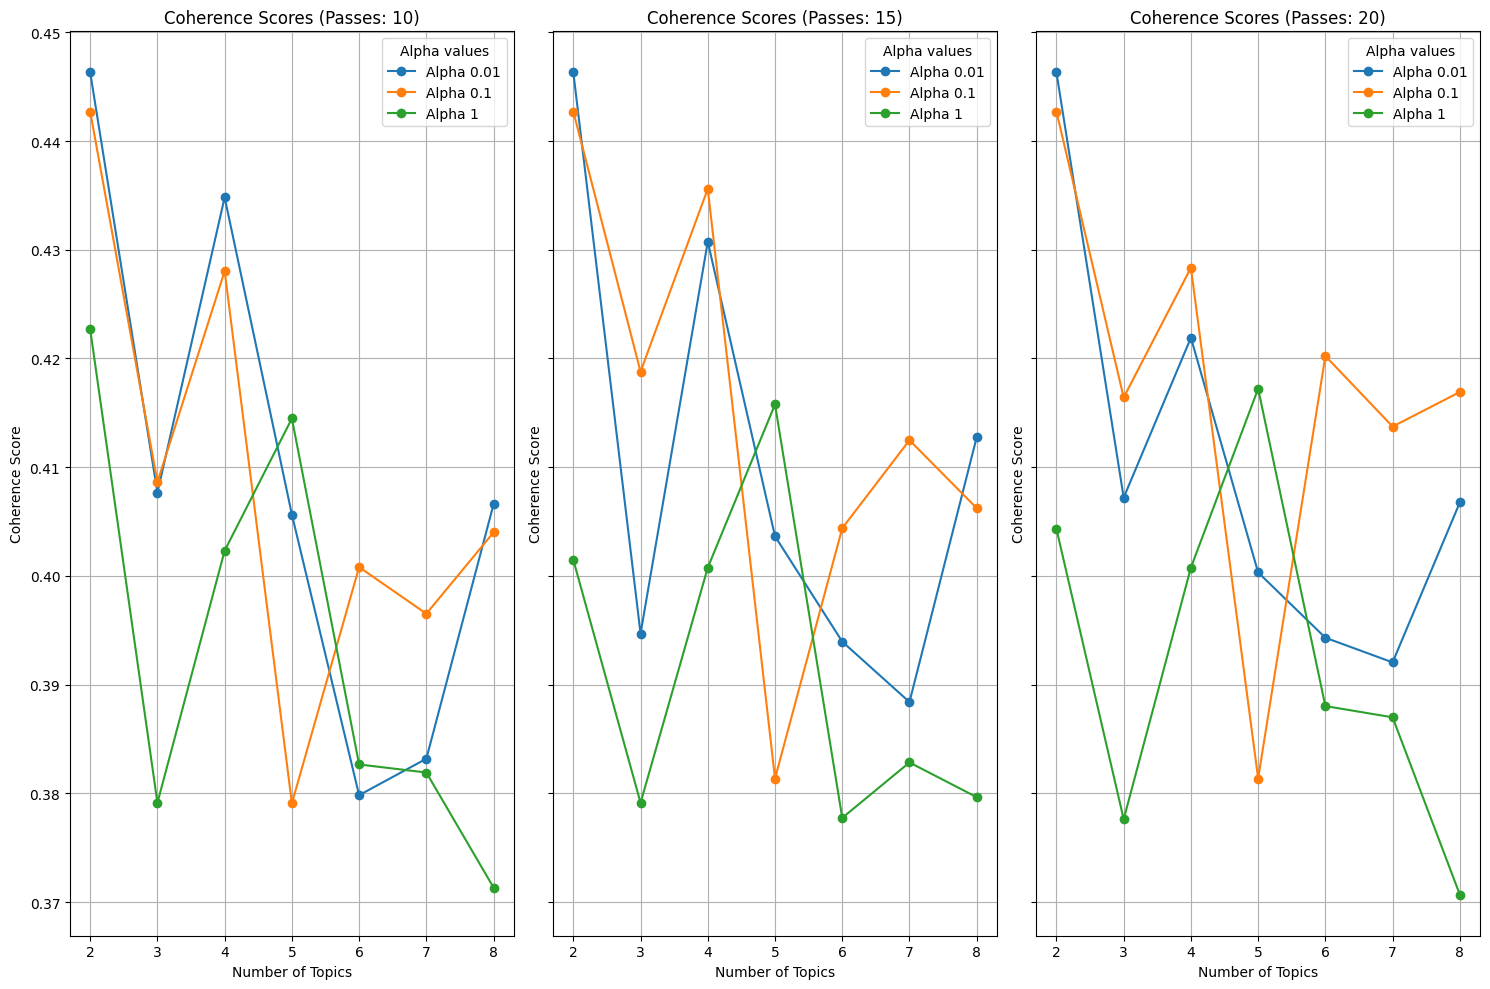

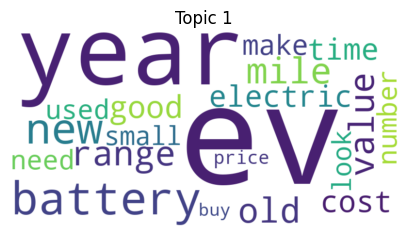

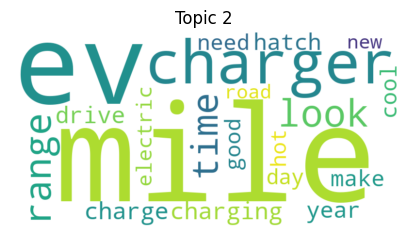

In [54]:
custom_stopwords = set(stopwords.words('english')).union({'car', 'cars', 
                             'black', 'grey', 'uh', 'yes', 'go', 'e', 'oh', 'still', 'chinese', 'ice', 'dont', 'doesnt', 'less',
                             'fiat', 'jeep', 'avenger', 'abarth', 'stellantis', 'hyundai', 'honda', 'kona','kind', 'mean', 'fat','um', 'yeah', 'okay',
                             'one', 'content', 'interests', 'activity', 'notice', 'also', 'would', 'going', 'be', 'much', 'comes',
                             'like', 'bit', 'quite', 'lot', 'well', 'really', 'get', 'got', 'little', 'feeling', 'think', 'actually',
                             'even', 'however', 'around', 'see', 'know',
                             'presented', 'example',
                             'people','work','take','something','end','say','ever','probably','im','could','thats','cant','many','ago','ive','thing','id',
                             'zoe','renault','thought','claimed','data'
})


# Processing the documents
processed_docs = [preprocess(doc) for doc in forums_500e['Text']]
dictionary = corpora.Dictionary(processed_docs)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

# Compute models and coherence
num_topics_range = range(2, 9)
alpha_range = [0.01, 0.1,  1]
passes_range = range(10, 21, 5)
model_list, coherence_results = compute_coherence_values(dictionary, bow_corpus, processed_docs, num_topics_range, alpha_range, passes_range)

# Finding and displaying the best model
optimal_result_rc500 = max(coherence_results, key=lambda x: x['coherence'])
print(f"Optimal settings: {optimal_result_rc500['num_topics']} topics, Alpha: {optimal_result_rc500['alpha']}, Passes: {optimal_result_rc500['passes']}, Coherence Score: {optimal_result_rc500['coherence']}")

# Assuming `coherence_results` is your list of dictionaries containing the coherence data
plot_coherence_scores(coherence_results)

# Visualize topics using word clouds
optimal_model_rc500 = optimal_result_rc500['model']
optimal_num_topics_rc500 = optimal_result_rc500['num_topics']
wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white', stopwords=custom_stopwords, random_state=RANDOM_SEED)
for i in range(optimal_num_topics_rc500):
    plt.figure(figsize=(5, 4))
    topic_words = dict(optimal_model_rc500.show_topic(i, 20))
    filtered_words = {word: freq for word, freq in topic_words.items() if word not in custom_stopwords}
    plt.imshow(wordcloud.generate_from_frequencies(filtered_words), interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {i + 1}")
    plt.show()

In [55]:
lda_rc500 = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, num_topics=optimal_num_topics_rc500, alpha=optimal_result_rc500['alpha'], passes=optimal_result_rc500['passes'], random_state=RANDOM_SEED)

In [56]:
for idx, topic in lda_rc500.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.012*"ev" + 0.011*"year" + 0.010*"battery" + 0.009*"new" + 0.006*"mile" + 0.005*"old" + 0.005*"range" + 0.005*"value" + 0.004*"good" + 0.004*"electric"
Topic: 1 
Words: 0.009*"mile" + 0.006*"ev" + 0.006*"charger" + 0.005*"look" + 0.005*"range" + 0.005*"time" + 0.004*"charge" + 0.004*"charging" + 0.004*"drive" + 0.004*"hatch"


In [57]:
# Visualise topics using pyLDAvis
rc500_vis = gensimvis.prepare(lda_rc500, bow_corpus, dictionary, sort_topics=False)  # Ensure reproducibility by setting sort_topics to False
pyLDAvis.display(rc500_vis)

In [58]:
# Get the topic distribution for each document
rc500_topic_matrix = [lda_rc500[doc] for doc in bow_corpus]

# Extract topic probabilities and add them as columns
forums_500e['Topic 1'] = [dict(doc).get(0, 0) for doc in rc500_topic_matrix]
forums_500e['Topic 2'] = [dict(doc).get(1, 0) for doc in rc500_topic_matrix]

# Display the table with the new topic columns
forums_500e.head()

,Date,URL,Text,ID,Topic 1,Topic 2
0,2023-07-21,https://www.speakev.com/threads/fiat-500e-icon...,we will receive our new fiat 500e icon 2 month...,0,0.000000,0.999001
1,2023-07-21,https://www.speakev.com/threads/fiat-500e-icon...,do i need a home ev charger or can it be plugg...,1,0.000000,0.998753
2,2023-07-21,https://www.speakev.com/threads/fiat-500e-icon...,if i do get an ev charger which one should i g...,2,0.000000,0.995049
3,2023-08-17,https://www.speakev.com/threads/what-charging-...,i have ordered a fiat 500e icon on lease which...,3,0.181958,0.818042
4,2023-08-17,https://www.speakev.com/threads/what-charging-...,so i took the plunge as i wanted a ev i do not...,4,0.000000,0.999583


In [59]:
# Apply sentiment analysis to each document
forums_500e['Sentiment'] = forums_500e['Text'].apply(get_sentiment)

# Determine the primary topic for each document
forums_500e['Primary_Topic'] = forums_500e[['Topic 1', 'Topic 2']].idxmax(axis=1)

# Calculate mean sentiment for each topic
topic_sentiment = forums_500e.groupby('Primary_Topic')['Sentiment'].mean()

print(topic_sentiment)


# Calculate mean sentiment for each topic monthly
forums_500e['Date'] = pd.to_datetime(forums_500e['Date'])
forums_500e['Month'] = forums_500e['Date'].dt.to_period('M')
monthly_topic_sentiment = forums_500e.groupby(['Primary_Topic', 'Month'])['Sentiment'].mean()
# Print per month, not per topic
monthly_topic_sentiment = forums_500e.pivot_table(index='Month', columns='Primary_Topic', values='Sentiment', aggfunc='mean')
print(monthly_topic_sentiment)

Primary_Topic
Topic 1    0.079554
Topic 2    0.112502
Name: Sentiment, dtype: float64
Primary_Topic   Topic 1   Topic 2
Month                            
2008-05       -0.082143  0.168155
2009-06       -0.046111  0.080187
2010-05        0.044864  0.191416
2010-09        0.150958  0.077321
2011-11        0.173889  0.276882
...                 ...       ...
2024-02        0.010913  0.341908
2024-03        0.054095  0.160542
2024-04        0.000000  0.004821
2024-06       -0.300000 -0.039583
2024-07        0.083333  0.131052

[108 rows x 2 columns]


In [60]:
# Check the proportion of negative sentiment articles
negative_sentiment = forums_500e[forums_500e['Sentiment'] < 0]
print(len(negative_sentiment)/len(forums_500e))
print(len(negative_sentiment))

# Check the proportion of negative sentiment articles per topic
negative_sentiment_per_topic = negative_sentiment.groupby('Primary_Topic').size()
total_articles_per_topic = forums_500e.groupby('Primary_Topic').size()
negative_sentiment_proportion_per_topic = negative_sentiment_per_topic / total_articles_per_topic
print(negative_sentiment_proportion_per_topic)

# Check the proportion of negative sentiment articles per month
negative_sentiment['Month'] = negative_sentiment['Date'].dt.to_period('M')
negative_sentiment_per_month = negative_sentiment.groupby('Month').size()
total_articles_per_month = forums_500e.groupby('Month').size()
negative_sentiment_proportion_per_month = negative_sentiment_per_month / total_articles_per_month
print(negative_sentiment_proportion_per_month)

0.17836010143702452
422
Primary_Topic
Topic 1    0.201105
Topic 2    0.164271
dtype: float64
Month
2008-05    0.100000
2009-06    0.095238
2010-05    0.176471
2010-09    0.150000
2011-11    0.071429
             ...   
2024-02         NaN
2024-03         NaN
2024-04    0.400000
2024-06    0.333333
2024-07    0.111111
Freq: M, Length: 108, dtype: float64


C:\Users\atani\AppData\Local\Temp\ipykernel_13016\3707172463.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_sentiment['Month'] = negative_sentiment['Date'].dt.to_period('M')


# Clustering Analysis

0.0
0.0
0.08833474218089603


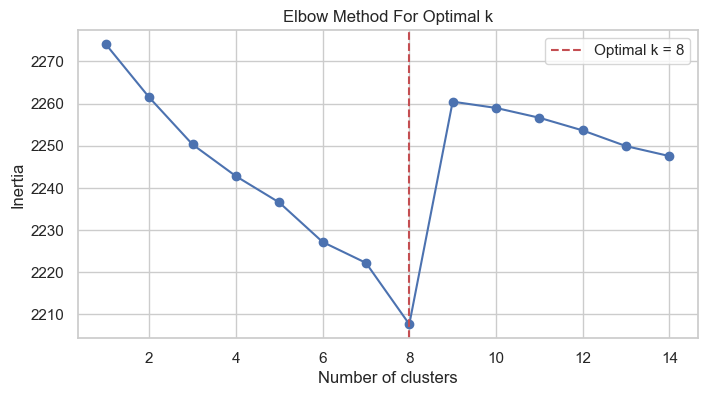

The optimal number of clusters based on the Elbow Method is: 8


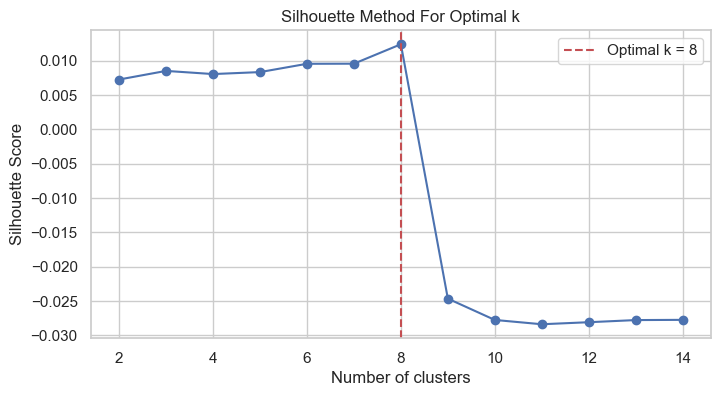

The optimal number of clusters based on the Silhouette Method is: 8


In [120]:
# Preprocess function
def preprocess(text):
    if isinstance(text, str):
        text = re.sub(r'\b\w{1,2}\b', '', text)  # Remove short words
        tokens = nltk.word_tokenize(text.lower())
        tokens = [word for word in tokens if word.isalpha() and word not in custom_stopwords]
        return ' '.join(tokens)  # Return processed text as a string
    else:
        return ''

# Custom stopwords
custom_stopwords = set(stopwords.words('english')).union({
    'car', 'cars', 'black', 'grey', 'uh', 'yes', 'go', 'e', 'oh', 'still', 'chinese', 
    'ice', 'dont', 'doesnt', 'less', 'fiat', 'jeep', 'avenger', 'abarth', 'stellantis', 
    'hyundai', 'honda', 'kona', 'kind', 'mean', 'fat', 'um', 'yeah', 'okay', 'one', 
    'content', 'interests', 'activity', 'notice', 'also', 'would', 'going', 'be', 'much', 
    'comes', 'like', 'bit', 'quite', 'lot', 'well', 'really', 'get', 'got', 'little', 
    'feeling', 'think', 'actually', 'even', 'however', 'around', 'see', 'know', 'presented', 
    'example', 'people', 'work', 'take', 'something', 'end', 'say', 'ever', 'probably', 
    'im', 'could', 'thats', 'cant', 'many', 'ago', 'ive', 'thing', 'id', 'zoe', 'renault', 
    'thought', 'claimed', 'data'
})

# Load the dataset
forums_500e_original = pd.read_csv(r'C:\Users\atani\OneDrive - City, University of London\Tanisha\ARP\500e - Forums_Merged_20240724.csv')
forums_500e = forums_500e_original.copy()

# Rename columns and add ID
forums_500e['ID'] = forums_500e.index
forums_500e.rename(columns={'Content': 'Text'}, inplace=True)

# Drop empty Text rows
forums_500e = forums_500e.dropna(subset=['Text'])

# Check proportions of null values
print(forums_500e['Text'].isnull().sum()/len(forums_500e))
print(forums_500e['ID'].isnull().sum()/len(forums_500e))
print(forums_500e['Date'].isnull().sum()/len(forums_500e))

# Process the documents
processed_docs = [preprocess(doc) for doc in forums_500e['Text']]

# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words=list(custom_stopwords))
X_tfidf = tfidf_vectorizer.fit_transform(processed_docs)

# Apply the Elbow Method to determine the optimal number of clusters
inertia = []
K_range = range(1, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    inertia.append(kmeans.inertia_)

# Find the "elbow" point
def find_elbow(inertia, K_range):
    slopes = np.diff(inertia)
    optimal_k = np.argmax(np.diff(slopes)) + 2  # +2 because np.diff reduces the array size by 1 and we start from k=2
    return optimal_k

optimal_k_elbow = find_elbow(inertia, K_range)

# Plotting the inertia to find the elbow
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.axvline(x=optimal_k_elbow, color='r', linestyle='--', label=f'Optimal k = {optimal_k_elbow}')
plt.legend()
plt.show()

print(f"The optimal number of clusters based on the Elbow Method is: {optimal_k_elbow}")

# Apply the Silhouette Method
silhouette_scores = []

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    silhouette_scores.append(silhouette_score(X_tfidf, kmeans.labels_))

optimal_k_silhouette = np.argmax(silhouette_scores) + 2  # +2 because the range starts from 2

# Plotting the silhouette scores to find the optimal number of clusters
plt.figure(figsize=(8, 4))
plt.plot(range(2, 15), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.axvline(x=optimal_k_silhouette, color='r', linestyle='--', label=f'Optimal k = {optimal_k_silhouette}')
plt.legend()
plt.show()

print(f"The optimal number of clusters based on the Silhouette Method is: {optimal_k_silhouette}")

# Decide on the optimal number of clusters
optimal_k = max(optimal_k_elbow, optimal_k_silhouette)  # Choose the higher number for better separation

Cluster 1 samples:
- surely the ultimate road trip car accommodating 4 would have to be the mercedes w124 wouldnt itsure the exotics are nice and all that but when you are covering 1000s of miles effortless cruising is wh...
- i wonder if anyone would be kind enough to help me with working out the rate for an ix that i test drove yesterdaymy journey data stateda total of 193 miles and 26kwh100km no idea why it was displayin...
- b they claim a top speed of 85kmph and a range of 150km what can one expect to get in real world conditions...


Cluster 2 samples:
- so the wifes fiat 500e will go from zero to 165year but my sons old megane diesel will go up from zero to 20year yeah seems fair i dont think anything ice will be less than 165 per year come 2025 lots...
- weve had a look at a couple of youtube reviews so are aware of the lack of side impact airbags but other than that the zoe looks like an excellent valueformoney proposition ive also seen this really h...
- i am surprise to see 

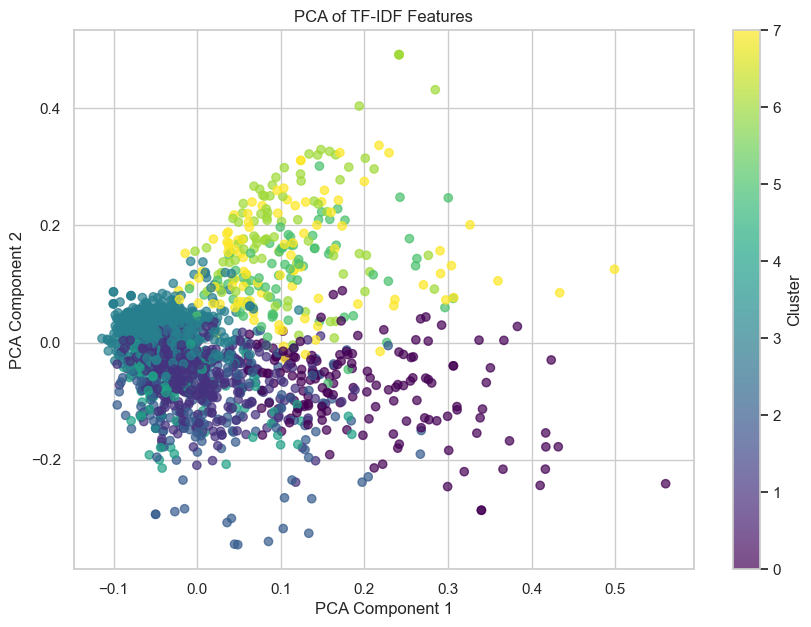

Cluster 1 Top Keywords: miles, range, day, per, charge, trip, kwh, mile, real, year

Cluster 2 Top Keywords: years, old, drive, great, look, evs, year, mini, good, way

Cluster 3 Top Keywords: new, battery, buy, anyone, used, prices, evs, year, etc, range

Cluster 4 Top Keywords: time, tesla, good, back, model, thanks, road, use, first, nissan

Cluster 5 Top Keywords: electric, mini, vehicle, new, news, fuel, drive, per, sold, make

Cluster 6 Top Keywords: charge, app, rate, set, home, need, wont, way, charging, battery

Cluster 7 Top Keywords: charging, home, situation, range, points, cable, chargers, public, zappi, rate

Cluster 8 Top Keywords: charger, home, cable, granny, charge, chargers, install, socket, miles, installed



In [121]:
# Apply K-Means Clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# Add cluster labels to the DataFrame
forums_500e['Cluster'] = clusters

# Print samples from each cluster
for cluster in range(optimal_k):
    print(f"Cluster {cluster + 1} samples:")
    samples = forums_500e[forums_500e['Cluster'] == cluster].sample(3, random_state=42)
    for index, row in samples.iterrows():
        print(f"- {row['Text'][:200]}...")  # Print the first 200 characters of each sample
    print("\n")

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of TF-IDF Features')
plt.show()

# Keyword Analysis for Each Cluster
feature_names = tfidf_vectorizer.get_feature_names_out()

for cluster in range(optimal_k):
    cluster_tfidf = X_tfidf[clusters == cluster]
    cluster_mean_tfidf = np.mean(cluster_tfidf, axis=0)
    
    if cluster_tfidf.shape[0] > 0:  # Check if the cluster_tfidf matrix is not empty
        # Ensure cluster_mean_tfidf is a 1D array
        cluster_mean_tfidf = np.array(cluster_mean_tfidf).flatten()
        
        # Get indices of top 10 features
        top_indices = np.argsort(cluster_mean_tfidf)[-10:][::-1]
        
        # Get top 10 keywords
        top_keywords = [feature_names[i] for i in top_indices]
        
        print(f"Cluster {cluster + 1} Top Keywords: {', '.join(top_keywords)}\n")